# 7. Logistic Regression Classification

Let's now start to build classification models, starting with logistic regression.

### Load the modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

### Load dataset

In [2]:
# Read in dataset
devon_cornwall = pd.read_csv('./data/dandc_crime_and_demographics.csv')
# Drop LSOA code - we will add this back in later for mapping
devon_cornwall = devon_cornwall.drop('lsoa_code', axis=1)
# Make data float type
devon_cornwall = devon_cornwall.astype(float)

### Hide warnings

In [3]:
# Hide warnings (to keep notebook tidy)
import warnings
warnings.filterwarnings("ignore")

## Total crime - high
As ever, let's build our first model for predicting total crime.

### Prepare labels

We are now looking to classify our data as one of a number of labels. Let's start by trying to predict the areas with the highest crime. We will label the top decile 1, and the rest 0.

We will need to do some more processing of the data to create these labels:

In [4]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['crime_total'], bin_edges = pd.qcut(devon_cornwall['crime_total'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [5]:
# Have a look at counts
devon_cornwall['crime_total'].value_counts()

0    930
1    104
Name: crime_total, dtype: int64

In [6]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       47.0     0
1      819.7     1

### Divide into features (X) and labels (y)

We will split into features (X) and labels (y) and convert these from pandas dataframes to NumPy arrays. These are simpler to refer to by row/column index numbers, which we will use for sklearn's k-fold method.

In [7]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['crime_total'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Standardise the data

Now we will write a function for standardising the data so that the features are on similar scales. We can use sklearn's StandardScaler method.

In [8]:
# Define function for standardising data
def standardise_data(X_train, X_test):   
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 
    # Set up the scaler just on the training set
    sc.fit(X_train)
    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

### Fit initial logistic regression model

In [9]:
# Define function for applying initial linear regression model
def initial_logistic_regression(X,y):

    # Set up lists to hold results for each k-fold run
    training_acc_results = []
    test_acc_results = []

    # Set up splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
    skf.get_n_splits(X, y)

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X, y):

        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_std,y_train)

        # Predict training and test set labels
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)

        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)

        # Add accuracy to lists
        training_acc_results.append(accuracy_train)
        test_acc_results.append(accuracy_test)
        
    return training_acc_results, test_acc_results

In [10]:
results = initial_logistic_regression(X,y)

In [11]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [12]:
# Show mean accuracy on test data
results[1]

[0.8942307692307693,
 0.9230769230769231,
 0.9230769230769231,
 0.9134615384615384,
 0.9902912621359223,
 0.9514563106796117,
 0.9320388349514563,
 0.8737864077669902,
 0.9223300970873787,
 0.9320388349514563]

In [13]:
# Define function to plot initial accuracy
def plot_initial_accuracy(results):
    # Plot the accuracy
    %matplotlib inline

    # Set up X data 
    x_for_box = [results[0], results[1]]

    # Set up X labels
    labels = ['Training', 'Test'] 

    # Set up figure
    fig = plt.figure(figsize=(5,5))

    # Add subplot (can be used to define multiple plots in same figure)
    ax1 = fig.add_subplot(1,1,1)

    # Define Box Plot (`widths` is optional)
    ax1.boxplot(x_for_box, 
                widths=0.7,
                whis=10)

    # Set X and Y labels
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Accuracy')

    # Show plot
    plt.show()

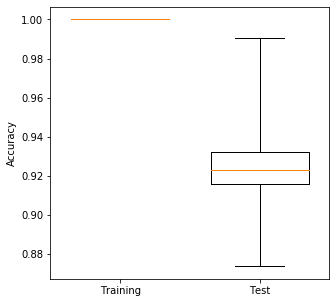

In [14]:
plot_initial_accuracy(results)

Let's see if we can improve the model.

### Feature selection

256 is a lot of features. Let's try univariate statistical selection to narrow down the number of features. This will allow us to expand to polynomial features afterwards (as 256 features creates nearly 33,000 polynomial features which is too many to handle easily!) 

In [15]:
from scipy.stats.stats import pearsonr

# Define function to create dataframe of features' correlation and significance
def univariate_statistical_selection(X_df,y_df):

    features = list(X_df)
    correlation = []
    significance = []
    for feature in features:
        correl = pearsonr(X_df[feature].to_numpy(),y_df.to_numpy())
        correlation.append(correl[0])
        significance.append(correl[1])
    df = pd.DataFrame()
    df['feature'] = features
    df['correlation'] = correlation
    df['abs_correlation'] = np.abs(correlation)
    df['significance'] = significance
    df['significant'] = df['significance'] < 0.05 
    df.sort_values(by='abs_correlation', ascending=False, inplace=True)
    
    return df

In [16]:
df = univariate_statistical_selection(X_df,y_df)

In [17]:
# Look at head of dataframe
df.head()

feature  correlation  abs_correlation   significance  significant
26   room_rating     0.603794         0.603794  9.939928e-104         True
22          flat     0.572522         0.572522   4.281444e-91         True
2        married    -0.522828         0.522828   1.317344e-73         True
14  new_eu_birth     0.516974         0.516974   9.859963e-72         True
23        owners    -0.502243         0.502243   3.561920e-67         True

In [18]:
# Count how many features are significant
(df.significant == True).sum()

195

This is still a very large number of features. Let's try and narrow this down further by visualising the effect of different numbers of features.

In [19]:
# Create list of ordered features
ordered_features = list(df['feature'])
# Create lists to store accuracies and ROC AUCs
accuracy_by_feature_number = []
roc_auc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)
for i in range(number_of_features):
    # print ("{0} features of {1}".format(i, number_of_features))
    features_to_use = ordered_features[0:i+1]
    X_selected = X_df[features_to_use]
    
    # Convert to NumPy (needed for k-fold method)
    # Convert DataFrames to NumPy arrays
    X_np = X_selected.values
    y_np = y_df.values
    
    #%% Run k fold model

    # Set up lists to hold results for each k-fold run
    test_acc_results = []
    test_auc_results = []

    # Set up splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
    skf.get_n_splits(X_np, y)

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(max_iter=10000)
        model.fit(X_train_std,y_train)

        # Predict test set labels
        y_pred_test = model.predict(X_test_std)
        
        # Calculate accuracy of test sets
        accuracy_test = np.mean(y_pred_test == y_test)
        test_acc_results.append(accuracy_test)
        
        # Get ROC AUC
        probabilities = model.predict_proba(X_test_std)
        probabilities = probabilities[:, 1] # Probability of high crime class
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        test_auc_results.append(roc_auc)  
        
    # Add mean accuracy and AUC to record of accuracy by feature number
    accuracy_by_feature_number.append(np.mean(test_acc_results))
    roc_auc_by_feature_number.append(np.mean(test_auc_results))

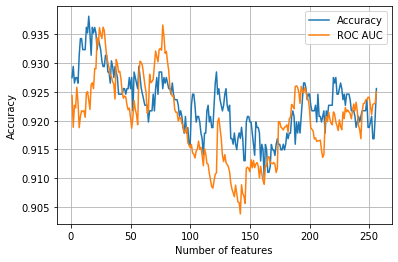

In [20]:
# Plot accuracy
%matplotlib inline

chart_x = list(range(1, number_of_features + 1))
plt.plot(chart_x, accuracy_by_feature_number,
        label = 'Accuracy')

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

Accuracy and ROC AUC peak at around 20 features.

In [21]:
# Define function that will return top 20 features
def top_20_features(df):
    ordered_features = list(df['feature'])
    top_features = ordered_features[0:20]
    return top_features

In [22]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.603794         0.603794  9.939928e-104   
22                    flat     0.572522         0.572522   4.281444e-91   
2                  married    -0.522828         0.522828   1.317344e-73   
14            new_eu_birth     0.516974         0.516974   9.859963e-72   
23                  owners    -0.502243         0.502243   3.561920e-67   
24            private_rent     0.495194         0.495194   4.518971e-65   
12           british_birth    -0.485034         0.485034   3.994894e-62   
1                   single     0.460639         0.460639   1.923809e-55   
15                language     0.456252         0.456252   2.688675e-54   
4                    white    -0.441956         0.441956   1.117230e-50   
5                    mixed     0.440188         0.440188   3.045068e-50   
33           two_plus_cars    -0.434159         0.434159   8.914597e-49   
241                    imd     0.426947         0.426947   4.630735e-47   
35       private_transport    -0.425349         0.425349   1.097162e-46   
36   alternative_transport     0.423963         0.423963   2.309503e-46   
253         wider_barriers     0.423193         0.423193   3.487468e-46   
243       employment_score     0.416216         0.416216   1.388531e-44   
37            unemployment     0.412749         0.412749   8.392383e-44   
249                 idaopi     0.407584         0.407584   1.177334e-42   
245           health_score     0.387024         0.387024   2.761403e-38   

     significant  
26          True  
22          True  
2           True  
14          True  
23          True  
24          True  
12          True  
1           True  
15          True  
4           True  
5           True  
33          True  
241         True  
35          True  
36          True  
253         True  
243         True  
37          True  
249         True  
245         True

In [23]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('crime_total')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('crime_total',axis=1) 
y_df = feature_selected['crime_total'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Polynomial features
To allow for feature interaction, let's create new features which are the products of two features.

In [24]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [25]:
# Look at shape of the normal and expanded dataframes
print ('Shape of X:', X.shape)
print ('Shape of X_poly:', X_poly.shape)

Shape of X: (1034, 20)
Shape of X_poly: (1034, 210)


We now have 210 features. Let's test them.

In [26]:
# Set up splits
seed = 42
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
skf.get_n_splits(X, y)
skf.get_n_splits(X_poly, y)

# Set up model type  
# Set up lists for results for each of k splits
training_k_results = []
test_k_results = []
training_k_results_poly = []
test_k_results_poly = []

# Loop through the k-fold splits
for train_index, test_index in skf.split(X, y):
        
    # Normal (non-polynomial model)       
    # Get X and Y train/test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    # Fit model 
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_std,y_train)
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    # Calculate accuracy of training and test sets
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)
    # Record accuracy for each k-fold split
    training_k_results.append(accuracy_train)
    test_k_results.append(accuracy_test)
        
    # Polynomial model (same as above except use X with polynomial features)       
    # Get X and Y train/test
    X_train, X_test = X_poly[train_index], X_poly[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    # Fit model 
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train_std,y_train)
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    # Calculate accuracy of training and test sets
    accuracy_train = np.mean(y_pred_train == y_train)
    accuracy_test = np.mean(y_pred_test == y_test)
    # Record accuracy for each k-fold split
    training_k_results_poly.append(accuracy_train)
    test_k_results_poly.append(accuracy_test)

In [27]:
# Look at mean non-poly training and test accuracy
np.mean(training_k_results), np.mean(test_k_results)

(0.9414357321876119, 0.9362023898431666)

In [28]:
# Look at mean poly training and test accuracy
np.mean(training_k_results_poly), np.mean(test_k_results_poly)

(0.9595964565792361, 0.92943427931292)

The accuracies for the polynomial model look encouraging. Next we'll do feature selection from our expanded features.

In [29]:
# Define function for performing feature selection from expanded features
def select_from_expanded_features(poly,X_poly,y):
    
    # Transfer polynomial X into a pandas DataFrame (as method use Pandas)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

    # Create list to store accuracies, AUC and chosen features
    accuracy_by_feature_number = []
    auc_by_feature_number = []
    chosen_features = []

    # Initialise chosen features list and run tracker
    available_features = list(poly.get_feature_names())
    run = 0
    number_of_features = len(list(X))

    # Loop through feature list to select next feature
    maximum_features_to_choose = 20

    for i in range(maximum_features_to_choose):

        # Track and pront progress
        run += 1
        print ('Feature run {} of {}'.format(run, maximum_features_to_choose))

        # Reset best feature and accuracy
        best_result = 0
        best_feature = ''

        # Loop through available features
        for feature in available_features:

            # Create copy of already chosen features to avoid original being changed
            features_to_use = chosen_features.copy()
            # Create a list of features from features already chosen + 1 new feature
            features_to_use.append(feature)
            # Get data for features, and convert to NumPy array
            X_np = X_poly_df[features_to_use].values

            # Set up lists to hold results for each selected features
            test_accuracy_results = []
            test_auc_results = []

            # Set up dataframe to hold actual and predicted values
            pred_df = pd.DataFrame()

            # Set up k-fold training/test splits
            number_of_splits = 10
            skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
            skf.get_n_splits(X_np, y)

            # Loop through the k-fold splits
            for train_index, test_index in skf.split(X_np, y):

                # Get X and Y train/test
                X_train, X_test = X_np[train_index], X_np[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Get X and Y train/test
                X_train_std, X_test_std = standardise_data(X_train, X_test)

                # Set up and fit model
                model = LogisticRegression(max_iter = 10000)
                model.fit(X_train_std,y_train)

                # Predict test set labels
                y_pred_test = model.predict(X_test_std)

                # Add actual and predicted values to dataframe
                d = {'actual': y_test, 'pred': y_pred_test}
                df = pd.DataFrame(data=d)
                pred_df = pd.concat([pred_df, df])

                # Calculate accuracy of test sets
                accuracy_test = np.mean(y_pred_test == y_test)
                test_accuracy_results.append(accuracy_test)

                # Get ROC AUC
                probabilities = model.predict_proba(X_test_std)
                probabilities = probabilities[:, 1] # Probability of high crime class
                fpr, tpr, thresholds = roc_curve(y_test, probabilities)
                roc_auc = auc(fpr, tpr)
                test_auc_results.append(roc_auc)

            # Get average result from all k-fold splits
            feature_accuracy = np.mean(test_accuracy_results)
            feature_auc = np.mean(test_auc_results)

            # Update chosen feature and result if this feature is a new best
            if feature_accuracy > best_result:
                best_result = feature_accuracy
                best_auc = feature_auc
                best_feature = feature

        # k-fold splits are complete    
        # Add mean accuracy and AUC to records of accuracy and AUC by feature number
        accuracy_by_feature_number.append(best_result)
        auc_by_feature_number.append(best_auc)
        chosen_features.append(best_feature)
        available_features.remove(best_feature)

    # Put results in DataFrame
    results = pd.DataFrame()
    results['feature to add'] = chosen_features
    results['accuracy'] = accuracy_by_feature_number
    results['auc'] = auc_by_feature_number
    
    return results, chosen_features

In [30]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [31]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x5 x12  0.931385  0.903284
1          x6 x11  0.942046  0.920938
2          x8 x16  0.947825  0.925543
3         x14 x18  0.947834  0.925161
4         x11 x19  0.948796  0.925826
5             x11  0.949767  0.925953
6             x19  0.949767  0.923265
7          x8 x13  0.949767  0.922063
8          x9 x11  0.949767  0.922111
9          x2 x19  0.949767  0.922014
10         x4 x17  0.949776  0.922170
11        x15 x18  0.950737  0.922131
12         x0 x19  0.950737  0.922023
13         x6 x19  0.950737  0.921906
14         x8 x11  0.950737  0.921603
15         x9 x19  0.949776  0.921310
16         x0 x18  0.949757  0.922502
17          x1 x2  0.951690  0.922014
18         x1 x15  0.951690  0.921681
19          x2 x3  0.951690  0.920577

In [32]:
# Define function to plot accuracy by number of features
def plot_accuracy(results_and_features):
    %matplotlib inline

    chart_x = list(range(1, 21))

    plt.plot(chart_x, results_and_features[0]['accuracy'],
            label = 'Accuracy')

    plt.plot(chart_x, results_and_features[0]['auc'],
            label = 'ROC AUC')

    plt.xlabel('Number of features')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

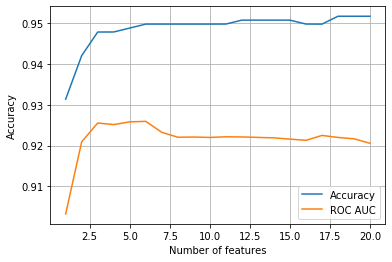

In [33]:
plot_accuracy(results_and_features)

The top 6 features would give us a high accuracy and a high ROC AUC.

### Regularisation

Now that we have settled on the top 6 polynomially-expanded features, let's work out the optimal regularisation value.

In [34]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:6]

# Define function to check different values of regularisation
def check_regularisation(X_poly, chosen_features, y_df):
    
    # Transfer polynomial X into a pandas DataFrame (as method use Pandas)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

    # List of regularisation values to try
    reg_values = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # Get data for features, and convert to NumPy array
    X_np = X_poly_df[chosen_features].values
    y_np = y_df.values

    # Set up lists to hold results
    training_acc_results = []
    test_acc_results = []

    # Set up splits
    skf = StratifiedKFold(n_splits = 10)
    skf.get_n_splits(X, y)

    # Set up model type

    for reg in reg_values:
        # Show progress
        print(reg, end=' ')

        # Set up lists for results for each of k splits
        training_k_results = []
        test_k_results = []
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X, y):
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y_np[train_index], y_np[test_index]
            # Standardise X data
            X_train_std, X_test_std = standardise_data(X_train, X_test)
            # Fit model with regularisation (C)
            model = LogisticRegression(C=reg, max_iter=10000)
            model.fit(X_train_std,y_train)
            # Predict training and test set labels
            y_pred_train = model.predict(X_train_std)
            y_pred_test = model.predict(X_test_std)
            # Calculate accuracy of training and test sets
            accuracy_train = np.mean(y_pred_train == y_train)
            accuracy_test = np.mean(y_pred_test == y_test)
            # Record accuracy for each k-fold split
            training_k_results.append(accuracy_train)
            test_k_results.append(accuracy_test)
        # Record average accuracy for each k-fold split
        training_acc_results.append(np.mean(training_k_results))
        test_acc_results.append(np.mean(test_k_results))
        
    # Plot results
    %matplotlib inline

    # Define data for chart
    x = reg_values
    y1 = training_acc_results
    y2 = test_acc_results

    # Set up figure
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)

    # Plot training set accuracy
    ax1.plot(x, y1,
            color = 'k',
            linestyle = '-',
            markersize = 8,
            marker = 'o',
            markerfacecolor='k',
            markeredgecolor='k',
            label  = 'Training set accuracy')

    # Plot test set accuracy
    ax1.plot(x, y2,
            color = 'r',
            linestyle = '-',
            markersize = 8,
            marker = 'o',
            markerfacecolor='r',
            markeredgecolor='r',
            label  = 'Test set accuracy')

    # Custimise axes
    ax1.grid(True, which='both')
    ax1.set_xlabel('Regularisation\n(lower value = greater regularisation)')
    ax1.set_ylabel('Accuracy')
    ax1.set_xscale('log')

    # Add legend
    ax1.legend()

    # Show plot
    plt.show()

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

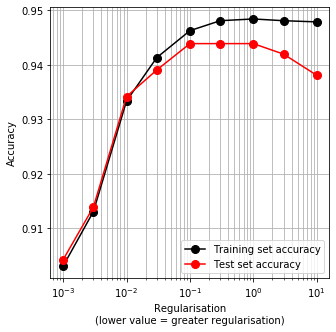

In [35]:
check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.1.

In [36]:
regularisation_value = 0.1

### Dealing with imbalanced data

Our data is highly imbalanced, so the model may end up biased towards the majority class and under-predicting the minority class. Let's try weighting the classes differently to penalise the model more when those classes are incorrectly predicted. 

In [37]:
# Define function to calculate various accuracy measurements
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

In [38]:
# Create dictionary of weights to try
weights = []
for weight in np.arange(0.02,0.99,0.02):
    weight_item = {0:weight, 1:1-weight}
    weights.append(weight_item)

In [39]:
# Define function to try different weights
def check_weights(X_poly, chosen_features, y):
    # Transfer polynomial X into a pandas DataFrame (as method use Pandas)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

    # Get data for features, and convert to NumPy array
    X_np = X_poly_df[chosen_features].values
    y_np = y_df.values

    # Create lists for overall results
    results_accuracy = []
    results_precision = []
    results_recall = []
    results_f1 = []
    results_predicted_positive_rate = []

    # Loop through list of model weights

    for weight in weights:

        # Create lists for k-fold results
        kfold_accuracy = []
        kfold_precision = []
        kfold_recall = []
        kfold_f1 = []
        kfold_predicted_positive_rate = []

        # Set up k-fold training/test splits
        number_of_splits = 10
        skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
        skf.get_n_splits(X_np, y_np)

        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):

            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y_np[train_index], y_np[test_index]

            # Get X and Y train/test
            X_train_std, X_test_std = standardise_data(X_train, X_test)

            # Set up and fit model
            model = LogisticRegression(max_iter = 10000, C=regularisation_value, class_weight=weight)
            model.fit(X_train_std,y_train)

            # Predict test set labels and get accuracy scores
            y_pred_test = model.predict(X_test_std)
            accuracy_scores = calculate_accuracy(y_test, y_pred_test)
            kfold_accuracy.append(accuracy_scores['accuracy'])
            kfold_precision.append(accuracy_scores['precision'])
            kfold_recall.append(accuracy_scores['recall'])
            kfold_f1.append(accuracy_scores['f1'])
            kfold_predicted_positive_rate.append(
                accuracy_scores['predicted_positive_rate'])

        # Add mean results to overall results
        results_accuracy.append(np.mean(kfold_accuracy))
        results_precision.append(np.mean(kfold_precision))
        results_recall.append(np.mean(kfold_recall))
        results_f1.append(np.mean(kfold_f1))
        results_predicted_positive_rate.append(
            np.mean(kfold_predicted_positive_rate))

    # Transfer results to dataframe
    results = pd.DataFrame(weights)
    results['accuracy'] = results_accuracy
    results['precision'] = results_precision
    results['recall'] = results_recall
    results['f1'] = results_f1
    results['predicted_positive_rate'] = results_predicted_positive_rate  
    
    # Plot results
    %matplotlib inline

    chart_x = results[1]

    plt.plot(chart_x, results['accuracy'],
             linestyle = '-',
             label = 'Accuracy')

    plt.plot(chart_x, results['precision'],
             linestyle = '--',
             label = 'Precision')

    plt.plot(chart_x, results['recall'],
             linestyle = '-.',
             label = 'Recall')

    plt.plot(chart_x, results['f1'],
             linestyle = ':',
             label = 'F1')

    plt.plot(chart_x, results['predicted_positive_rate'],
             linestyle = '-',
             label = 'Predicted positive rate')

    actual_positive_rate = np.repeat(y.codes.mean(), len(chart_x))

    plt.plot(chart_x, actual_positive_rate,
             linestyle = '--',
             color='k',
             label = 'Actual positive rate')


    plt.xlabel('Weight of high crime')
    plt.ylabel('Score')
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    plt.legend(loc='lower left')
    plt.grid(True)

    plt.show()

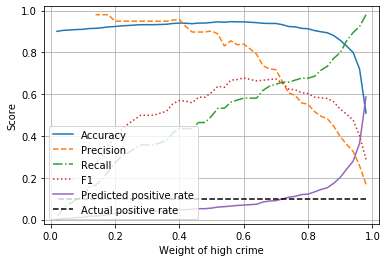

In [40]:
check_weights(X_poly, chosen_features, y)

Accuracy is maximised when classes are equally weighted, but the minority class ('high crime') is under-predicted. A weight of 0.7 for high crime balances precision and recall and correctly estimates the proportion of LSOAs that are high crime. There is a marginal accuracy in overall accuracy in order to balance accuracy of the classes.

In [41]:
weight = {0:0.3,1:0.7}

We can also deal with imbalanced data by under-sampling the majority class/over-sampling the minority class. Let's try the former first.

In [42]:
# Define function to reduce minority class
def reduce_majority_class(X, y, maj_sample_size=100):
    """
    Identify majority class (for binary classification of y) and reduce 
    size of majority class to `n` (defaults to 100). Uses bootstrap sampling,
    so will not error if requested sample size is greater than available 
    samples.
    
    Input: X and y NumPy arrays
    Output X and y NumPy arrays
    """
    
    # Get majority class
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    index_max = counts_elements.argmax()
    majority_class = unique_elements[index_max]

    # Separate out classes by index
    majority_index = np.where(y == majority_class)[0]
    minority_index = np.where(y != majority_class)[0]
    
    # Sample from majority class
    restricted_sample_index = np.random.choice(
            majority_index, maj_sample_size, replace=True)
    
    # Get restricted X and y for restricted data
    X_majority_restricted = X[restricted_sample_index, :]
    y_majority_restricted = y[restricted_sample_index]
    
    # Get all of minority class
    X_minority = X[minority_index, :]
    y_minority = y[minority_index]
    
    # Combine X and y 
    X_new = np.concatenate([X_majority_restricted, X_minority])
    y_new = np.concatenate([y_majority_restricted, y_minority])
    
    # Shuffle (use random index to shuffle X and y in same order)
    count_rows = X_new.shape[0]
    random_index = np.random.permutation(count_rows)
    X_new = X_new[random_index, :]
    y_new = y_new[random_index]
    
    return X_new, y_new

In [43]:
# Transfer polynomial X into a pandas DataFrame (as method use Pandas)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

# Get data for features, and convert to NumPy array
X_np = X_poly_df[chosen_features].values
y_np = y_df.values

# Create lists for overall results
results_raw_majority_count = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []

samples_sizes = list(np.arange(50, 1001, 50))
for maj_sample_size in samples_sizes:

    # Set up loop for replicates for each training majority class size
    replicate_raw_majority_count = []
    replicate_accuracy = []
    replicate_precision = []
    replicate_recall = []
    replicate_f1 = []
    replicate_predicted_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train_full, X_test = X_np[train_index], X_np[test_index]
        y_train_full, y_test = y_np[train_index], y_np[test_index]
        
        # Record original training majority class
        count_of_training_died = (y_train_full == 0).sum()
        replicate_raw_majority_count.append(count_of_training_died)
        
        # Get restricted training set
        X_train, y_train = reduce_majority_class(
                X_train_full, y_train_full, maj_sample_size)
        
        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        
        # Set up and fit model
        model = LogisticRegression(max_iter = 10000, C=regularisation_value)
        model.fit(X_train_std,y_train)
        
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        replicate_accuracy.append(accuracy_scores['accuracy'])
        replicate_precision.append(accuracy_scores['precision'])
        replicate_recall.append(accuracy_scores['recall'])
        replicate_f1.append(accuracy_scores['f1'])
        replicate_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
                        
    # Add mean results to overall results
    results_raw_majority_count.append(np.mean(replicate_raw_majority_count))
    results_accuracy.append(np.mean(replicate_accuracy))
    results_precision.append(np.mean(replicate_precision))
    results_recall.append(np.mean(replicate_recall))
    results_f1.append(np.mean(replicate_f1))
    results_predicted_positive_rate.append(
        np.mean(replicate_predicted_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(samples_sizes, columns=['Sample_size'])
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate

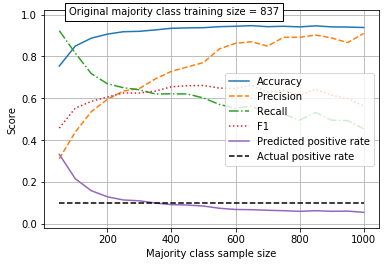

In [44]:
# Plot results
%matplotlib inline

chart_x = results['Sample_size']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.codes.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')

# Add text showing original majority class training size
original_majority_training_sample = int(np.mean(results_raw_majority_count))
text = 'Original majority class training size = ' + str(
    original_majority_training_sample)


plt.text(80, 1.0,text, bbox=dict(facecolor='white', alpha=1.0))

plt.xlabel('Majority class sample size')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='center right')
plt.grid(True)

plt.show()

Without under-sampling, the minority class (high crime) is under-predicted. By under-sampling the model becomes more balanced and correctly predicts the proportion of LSOAs with high crime. 
Let's now try over-sampling the minority class. 

In [45]:
# Define function to over-sample the minority class

def increase_minority(X, y, maj_sample_size=100):
    """
    Identify majority class (for binary classification of y) and reduce 
    size of majority class to `n` (defaults to 100). Uses bootstrap sampling,
    so will not error if requested sample size is greater than available 
    samples.
    
    Input: X and y NumPy arrays
    Output X and y NumPy arrays
    """
    
    # Get minority class
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    index_max = counts_elements.argmin()
    minority_class = unique_elements[index_max]

    # Separate out classes by index
    minority_index = np.where(y == minority_class)[0]
    majority_index = np.where(y != minority_class)[0]
    
    # Sample from majority class
    enhanced_sample_index = np.random.choice(
            minority_index, maj_sample_size, replace=True)
    
    # Get restricted X and y for restricted data
    X_minority_enhanced = X[enhanced_sample_index, :]
    y_minority_enhanced = y[enhanced_sample_index]
    
    # Get all of majority class
    X_majority = X[majority_index, :]
    y_majority = y[majority_index]
    
    # Combine X and y 
    X_new = np.concatenate([X_minority_enhanced, X_majority])
    y_new = np.concatenate([y_minority_enhanced, y_majority])
    
    # Shuffle (use random index to shuffle X and y in same order)
    count_rows = X_new.shape[0]
    random_index = np.random.permutation(count_rows)
    X_new = X_new[random_index, :]
    y_new = y_new[random_index]
    
    return X_new, y_new

In [46]:
# Transfer polynomial X into a pandas DataFrame (as method use Pandas)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

# Get data for features, and convert to NumPy array
X_np = X_poly_df[chosen_features].values
y_np = y_df.values

# Create lists for overall results
results_raw_minority_count = []
results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []

samples_sizes = list(np.arange(50, 1001, 50))
for maj_sample_size in samples_sizes:

    # Set up loop for replicates for each training majority class size
    replicate_raw_minority_count = []
    replicate_accuracy = []
    replicate_precision = []
    replicate_recall = []
    replicate_f1 = []
    replicate_predicted_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train_full, X_test = X_np[train_index], X_np[test_index]
        y_train_full, y_test = y_np[train_index], y_np[test_index]
        
        # Record original training majority class
        count_of_training_survived = (y_train_full == 1).sum()
        replicate_raw_minority_count.append(count_of_training_survived)
        
        # Get enhanced training set
        X_train, y_train = increase_minority(
                X_train_full, y_train_full, maj_sample_size)
        
        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        
        # Set up and fit model
        model = LogisticRegression(max_iter=10000, C= regularisation_value)
        model.fit(X_train_std,y_train)
        
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        replicate_accuracy.append(accuracy_scores['accuracy'])
        replicate_precision.append(accuracy_scores['precision'])
        replicate_recall.append(accuracy_scores['recall'])
        replicate_f1.append(accuracy_scores['f1'])
        replicate_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
                        
    # Add mean results to overall results
    results_raw_minority_count.append(np.mean(replicate_raw_minority_count))
    results_accuracy.append(np.mean(replicate_accuracy))
    results_precision.append(np.mean(replicate_precision))
    results_recall.append(np.mean(replicate_recall))
    results_f1.append(np.mean(replicate_f1))
    results_predicted_positive_rate.append(
        np.mean(replicate_predicted_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(samples_sizes, columns=['Sample_size'])
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate

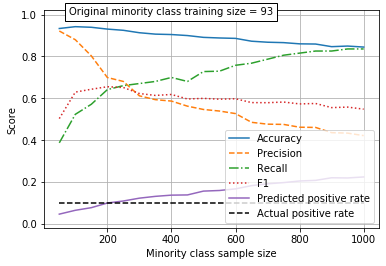

In [47]:
# Plot results
%matplotlib inline

chart_x = results['Sample_size']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.codes.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')

# Add text showing original majority class training size
original_minority_training_sample = int(np.mean(results_raw_minority_count))
text = 'Original minority class training size = ' + str(
    original_minority_training_sample)


plt.text(80, 1.0,text, bbox=dict(facecolor='white', alpha=1.0))

plt.xlabel('Minority class sample size')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

Without over-sampling, the minority class (high crime) is under-predicted. By over-sampling the model becomes more balanced and correctly predicts the proportion of LSOAs with high crime. There is a small reduction in overall accuracy.

Finally, let's also try changing the classification cut-off levels. 

In [48]:
# Transfer polynomial X into a pandas DataFrame (as method use Pandas)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

# Get data for features, and convert to NumPy array
X_np = X_poly_df[chosen_features].values
y_np = y_df.values

# Set up k-fold training/test splits
number_of_splits = 10
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X_np, y_np)

# Set up thresholds
thresholds = np.arange(0, 1.01, 0.2)

# Create arrays for overall results (rows=threshold, columns=k fold replicate)
results_accuracy = np.zeros((len(thresholds),number_of_splits))
results_precision = np.zeros((len(thresholds),number_of_splits))
results_recall = np.zeros((len(thresholds),number_of_splits))
results_f1 = np.zeros((len(thresholds),number_of_splits))
results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))

# Loop through the k-fold splits
loop_index = 0
for train_index, test_index in skf.split(X_np, y_np):
    
    # Create lists for k-fold results
    threshold_accuracy = []
    threshold_precision = []
    threshold_recall = []
    threshold_f1 = []
    threshold_predicted_positive_rate = []

    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # Get X and Y train/test
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Set up and fit model
    model = LogisticRegression(max_iter=10000, C=regularisation_value)
    model.fit(X_train_std,y_train)
    
    # Get probability of non-survive and survive
    probabilities = model.predict_proba(X_test_std)
    # Take just the survival probabilities (column 1)
    probability_survival = probabilities[:,1]
    
    # Loop through increments in probability of survival
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_survived = probability_survival >= cutoff
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_survived)
        # Add accuracy scores to lists
        threshold_accuracy.append(accuracy['accuracy'])
        threshold_precision.append(accuracy['precision'])
        threshold_recall.append(accuracy['recall'])
        threshold_f1.append(accuracy['f1'])
        threshold_predicted_positive_rate.append(accuracy['predicted_positive_rate'])
    
    # Add results to results arrays
    results_accuracy[:,loop_index] = threshold_accuracy
    results_precision[:, loop_index] = threshold_precision
    results_recall[:, loop_index] = threshold_recall
    results_f1[:, loop_index] = threshold_f1
    results_predicted_positive_rate[:, loop_index] = threshold_predicted_positive_rate
    
    # Increment loop index
    loop_index += 1
    

# Transfer results to dataframe
results = pd.DataFrame(thresholds, columns=['thresholds'])
results['accuracy'] = results_accuracy.mean(axis=1)
results['precision'] = results_precision.mean(axis=1)
results['recall'] = results_recall.mean(axis=1)
results['f1'] = results_f1.mean(axis=1)
results['predicted_positive_rate'] = results_predicted_positive_rate.mean(axis=1)

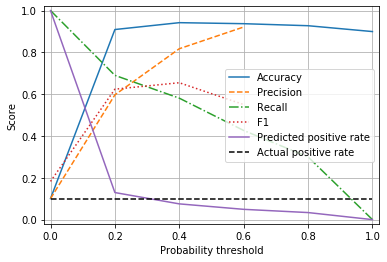

In [49]:
# Plot results
%matplotlib inline

chart_x = results['thresholds']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

actual_positive_rate = np.repeat(y.codes.mean(), len(chart_x))

plt.plot(chart_x, actual_positive_rate,
         linestyle = '--',
         color='k',
         label = 'Actual positive rate')


plt.xlabel('Probability threshold')
plt.ylabel('Score')
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.legend(loc='right')
plt.grid(True)

plt.show()

Accuracy is maximised with a probability threshold of 0.4, but at this threshold the minority class is under-predicted. A threshold of about 0.25 balances precision and recall and almost correctly estimates the proportion of LSOAs with high crime. There is a marginal reduction in overall accuracy to achieve this. 

Of our methods, the first seemed to be best as the one class weight allowed for the proportion of LSOAs that are high crime to be correctly estimated AND balanced precision, recall and F1. Let's use that final model:

In [50]:
# Define function for getting results from final model with selected weights
def weighted_logistic_regression(X_poly, chosen_features, y):
    # Transfer polynomial X into a pandas DataFrame (as method use Pandas)
    X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())
    
    # Get data for features, and convert to NumPy array
    X_np = X_poly_df[chosen_features].values
    y_np = y_df.values

    # Create lists for k-fold results
    kfold_accuracy = []
    kfold_precision = []
    kfold_recall = []
    kfold_f1 = []
    kfold_predicted_positive_rate = []

    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
    skf.get_n_splits(X_np, y_np)

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):

        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(max_iter = 10000, C=regularisation_value, class_weight = weight)
        model.fit(X_train_std,y_train)

        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        kfold_accuracy.append(accuracy_scores['accuracy'])
        kfold_precision.append(accuracy_scores['precision'])
        kfold_recall.append(accuracy_scores['recall'])
        kfold_f1.append(accuracy_scores['f1'])
        kfold_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])

    # Add mean results to overall results
    results_accuracy=np.mean(kfold_accuracy)
    results_precision=np.mean(kfold_precision)
    results_recall=np.mean(kfold_recall)
    results_f1=np.mean(kfold_f1)
    results_predicted_positive_rate=np.mean(kfold_predicted_positive_rate)
    results = [results_accuracy, results_precision, results_recall, results_f1, results_predicted_positive_rate]
    
    return results

In [51]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [52]:
results

[0.9381628080657208,
 0.716969696969697,
 0.6472727272727272,
 0.6732728822754399,
 0.09090739357729649]

## Antisocial behaviour

Now we'll build models for the different crime types.

In [53]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['antisocial'], bin_edges = pd.qcut(devon_cornwall['antisocial'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [54]:
# Have a look at counts
devon_cornwall['antisocial'].value_counts()

0    930
1    104
Name: antisocial, dtype: int64

In [55]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        7.0     0
1      244.7     1

In [56]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['antisocial'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [57]:
results = initial_logistic_regression(X,y)

In [58]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [59]:
# Show mean accuracy on test data
results[1]

[0.9326923076923077,
 0.9423076923076923,
 0.9038461538461539,
 0.8942307692307693,
 0.970873786407767,
 0.912621359223301,
 0.9029126213592233,
 0.941747572815534,
 0.941747572815534,
 0.9223300970873787]

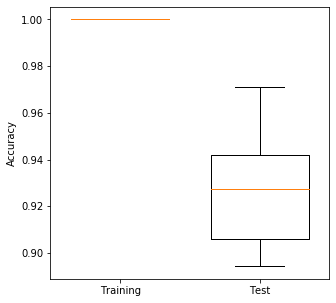

In [60]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [61]:
df = univariate_statistical_selection(X_df,y_df)

In [62]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.602357         0.602357  4.061824e-103   
22                    flat     0.580170         0.580170   4.653798e-94   
2                  married    -0.508335         0.508335   4.940105e-69   
23                  owners    -0.505020         0.505020   5.124456e-68   
14            new_eu_birth     0.488349         0.488349   4.477958e-63   
24            private_rent     0.450571         0.450571   7.730371e-53   
33           two_plus_cars    -0.450179         0.450179   9.719077e-53   
241                    imd     0.449936         0.449936   1.120622e-52   
243       employment_score     0.447516         0.447516   4.583320e-52   
12           british_birth    -0.438139         0.438139   9.670321e-50   
37            unemployment     0.432589         0.432589   2.124156e-48   
15                language     0.431375         0.431375   4.143315e-48   
1                   single     0.421461         0.421461   8.775792e-46   
35       private_transport    -0.419554         0.419554   2.408925e-45   
249                 idaopi     0.419413         0.419413   2.595141e-45   
242           income_score     0.418063         0.418063   5.280084e-45   
253         wider_barriers     0.417667         0.417667   6.500167e-45   
36   alternative_transport     0.408548         0.408548   7.215647e-43   
245           health_score     0.400652         0.400652   3.791303e-41   
4                    white    -0.399240         0.399240   7.616705e-41   

     significant  
26          True  
22          True  
2           True  
23          True  
14          True  
24          True  
33          True  
241         True  
243         True  
12          True  
37          True  
15          True  
1           True  
35          True  
249         True  
242         True  
253         True  
36          True  
245         True  
4           True

In [63]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('antisocial')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('antisocial',axis=1) 
y_df = feature_selected['antisocial'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [64]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [65]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [66]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x0 x7  0.933262  0.928866
1         x16 x18  0.940039  0.925024
2          x0 x11  0.941972  0.925836
3              x6  0.943904  0.930205
4           x0 x8  0.946817  0.930684
5          x7 x13  0.947788  0.930127
6          x7 x12  0.947788  0.929482
7          x2 x15  0.947788  0.928778
8          x7 x17  0.948749  0.927537
9              x3  0.948749  0.927312
10          x0 x5  0.948749  0.926285
11            x15  0.948749  0.926716
12         x0 x15  0.948749  0.926608
13         x2 x16  0.948749  0.925455
14         x0 x17  0.948749  0.925015
15         x1 x18  0.948749  0.923109
16         x2 x17  0.948749  0.922962
17          x3 x9  0.948749  0.922659
18         x3 x16  0.948749  0.923372
19         x3 x19  0.948749  0.923284

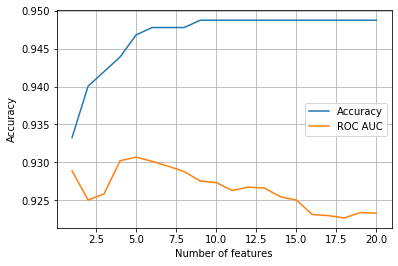

In [67]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

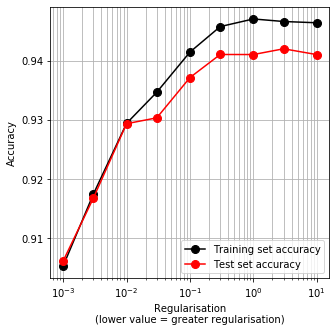

In [68]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 3.

In [69]:
regularisation_value = 3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

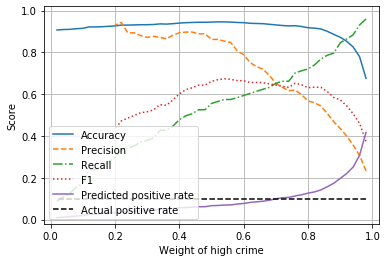

In [70]:
check_weights(X_poly, chosen_features, y)

A weight of 0.7 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [71]:
weight = {0:0.3,1:0.7}

In [72]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [73]:
results

[0.9313106796116504,
 0.651975246975247,
 0.6518181818181817,
 0.6437959057140643,
 0.09958924570575056]

## Bike theft

In [74]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['bike_theft'], bin_edges = pd.qcut(devon_cornwall['bike_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [75]:
# Have a look at counts
devon_cornwall['bike_theft'].value_counts()

0    933
1    101
Name: bike_theft, dtype: int64

In [76]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [77]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['bike_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [78]:
results = initial_logistic_regression(X,y)

In [79]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [80]:
# Show mean accuracy on test data
results[1]

[0.9134615384615384,
 0.9326923076923077,
 0.875,
 0.9134615384615384,
 0.941747572815534,
 0.8932038834951457,
 0.9029126213592233,
 0.9223300970873787,
 0.8932038834951457,
 0.883495145631068]

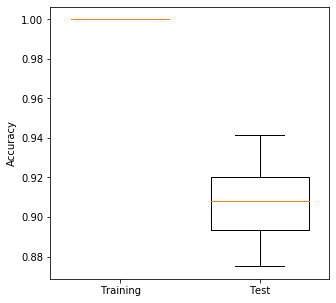

In [81]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [82]:
df = univariate_statistical_selection(X_df,y_df)

In [83]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
12           british_birth    -0.556281         0.556281  4.718254e-85   
4                    white    -0.537498         0.537498  1.814188e-78   
36   alternative_transport     0.507293         0.507293  1.033234e-68   
26             room_rating     0.503214         0.503214  1.811938e-67   
35       private_transport    -0.497223         0.497223  1.134224e-65   
5                    mixed     0.486749         0.486749  1.291513e-62   
1                   single     0.474326         0.474326  3.994771e-59   
9                  chinese     0.459803         0.459803  3.188112e-55   
22                    flat     0.459496         0.459496  3.837140e-55   
2                  married    -0.456257         0.456257  2.679620e-54   
24            private_rent     0.444720         0.444720  2.300942e-51   
14            new_eu_birth     0.444480         0.444480  2.640580e-51   
11                    arab     0.431916         0.431916  3.076669e-48   
83                    m_25     0.419014         0.419014  3.201584e-45   
13            old_eu_birth     0.418542         0.418542  4.104906e-45   
84                    m_26     0.418238         0.418238  4.817176e-45   
174                   f_24     0.410576         0.410576  2.563574e-43   
85                    m_27     0.407661         0.407661  1.131887e-42   
82                    m_24     0.403629         0.403629  8.621527e-42   
86                    m_28     0.402062         0.402062  1.883918e-41   

     significant  
12          True  
4           True  
36          True  
26          True  
35          True  
5           True  
1           True  
9           True  
22          True  
2           True  
24          True  
14          True  
11          True  
83          True  
13          True  
84          True  
174         True  
85          True  
82          True  
86          True

In [84]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('bike_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('bike_theft',axis=1) 
y_df = feature_selected['bike_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [85]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [86]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [87]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x2 x5  0.932310  0.895241
1          x8 x15  0.937145  0.901349
2         x12 x14  0.940058  0.901256
3          x4 x15  0.941019  0.898101
4         x14 x19  0.941990  0.898442
5         x16 x17  0.942952  0.897359
6         x14 x15  0.942952  0.897017
7             x10  0.942952  0.894922
8          x0 x10  0.942952  0.895244
9             x13  0.942952  0.894159
10         x0 x13  0.942952  0.893944
11         x1 x13  0.942952  0.893837
12         x4 x11  0.942952  0.892397
13         x8 x17  0.941990  0.891547
14        x10 x19  0.941029  0.894379
15         x1 x10  0.941029  0.893842
16          x6 x9  0.941029  0.891883
17         x6 x19  0.941019  0.889778
18             x3  0.941019  0.887449
19          x0 x3  0.941019  0.887664

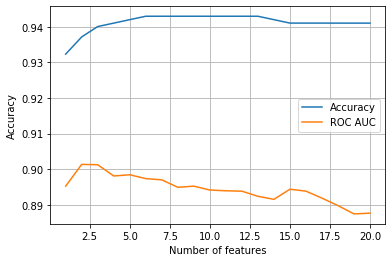

In [88]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

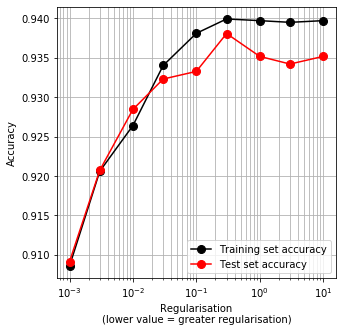

In [89]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.3.

In [90]:
regularisation_value = 0.3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

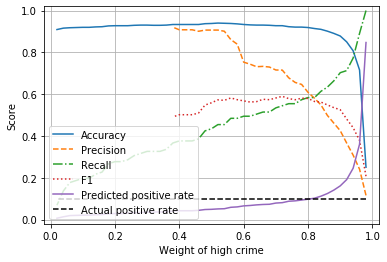

In [91]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [92]:
weight = {0:0.2,1:0.8}

In [93]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [94]:
results

[0.9188106796116505,
 0.6085393772893772,
 0.5836363636363636,
 0.5795151694000799,
 0.09755414488424197]

## Burglary

In [95]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['burglary'], bin_edges = pd.qcut(devon_cornwall['burglary'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [96]:
# Have a look at counts
devon_cornwall['burglary'].value_counts()

0    930
1    104
Name: burglary, dtype: int64

In [97]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       33.7     1

In [98]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['burglary'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [99]:
results = initial_logistic_regression(X,y)

In [100]:
# Show mean accuracy on training data
results[0]

[0.9989247311827957,
 0.9978494623655914,
 0.9978494623655914,
 0.9978494623655914,
 0.9978517722878625,
 0.9989258861439313,
 0.9978517722878625,
 0.9978517722878625,
 0.9989258861439313,
 0.9978517722878625]

In [101]:
# Show mean accuracy on test data
results[1]

[0.875,
 0.8557692307692307,
 0.9230769230769231,
 0.9038461538461539,
 0.883495145631068,
 0.8543689320388349,
 0.9029126213592233,
 0.9029126213592233,
 0.941747572815534,
 0.9029126213592233]

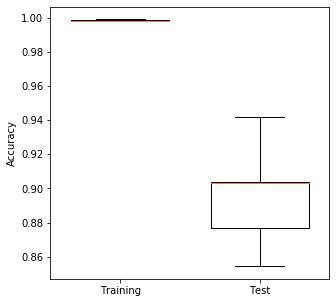

In [102]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [103]:
df = univariate_statistical_selection(X_df,y_df)

In [104]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.543069         0.543069  2.232754e-80   
22                    flat     0.537118         0.537118  2.441417e-78   
24            private_rent     0.496395         0.496395  1.995706e-65   
14            new_eu_birth     0.494618         0.494618  6.681747e-65   
2                  married    -0.479419         0.479419  1.541559e-60   
12           british_birth    -0.474293         0.474293  4.078957e-59   
1                   single     0.440516         0.440516  2.529385e-50   
4                    white    -0.439884         0.439884  3.617592e-50   
23                  owners    -0.428117         0.428117  2.455777e-47   
15                language     0.409918         0.409918  3.589246e-43   
5                    mixed     0.401598         0.401598  2.372400e-41   
10                   black     0.394884         0.394884  6.408450e-40   
174                   f_24     0.393182         0.393182  1.459887e-39   
35       private_transport    -0.385521         0.385521  5.606267e-38   
83                    m_25     0.377212         0.377212  2.629180e-36   
36   alternative_transport     0.374344         0.374344  9.672951e-36   
33           two_plus_cars    -0.371307         0.371307  3.788738e-35   
173                   f_23     0.366246         0.366246  3.568895e-34   
28             unpaid_care    -0.364843         0.364843  6.599248e-34   
253         wider_barriers     0.361225         0.361225  3.175356e-33   

     significant  
26          True  
22          True  
24          True  
14          True  
2           True  
12          True  
1           True  
4           True  
23          True  
15          True  
5           True  
10          True  
174         True  
35          True  
83          True  
36          True  
33          True  
173         True  
28          True  
253         True

In [105]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('burglary')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('burglary',axis=1) 
y_df = feature_selected['burglary'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [106]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [107]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [108]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x3 x19  0.924552  0.810870
1              x1  0.931329  0.871740
2         x14 x17  0.932319  0.877498
3          x0 x14  0.934242  0.875523
4             x17  0.934242  0.874721
5          x0 x16  0.934242  0.872600
6             x10  0.934242  0.871476
7          x7 x17  0.934242  0.872102
8         x10 x16  0.934242  0.868446
9             x13  0.934242  0.866755
10            x19  0.934242  0.860987
11          x1 x7  0.934242  0.860753
12        x15 x16  0.934242  0.852727
13         x5 x19  0.934242  0.853040
14         x7 x19  0.934242  0.852825
15          x1 x5  0.933271  0.853060
16         x1 x13  0.933271  0.852727
17          x1 x8  0.933280  0.852063
18         x2 x19  0.933280  0.853470
19         x5 x10  0.933280  0.854330

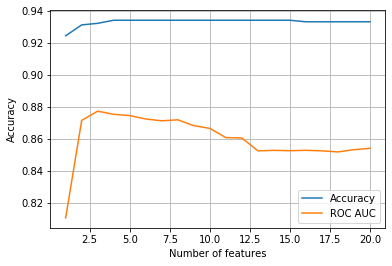

In [109]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

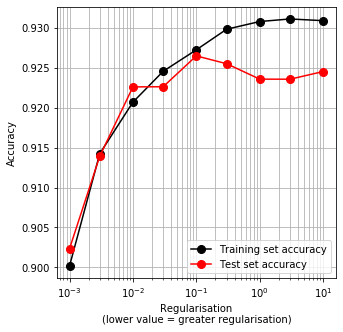

In [110]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:4]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.1.

In [111]:
regularisation_value = 0.1

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

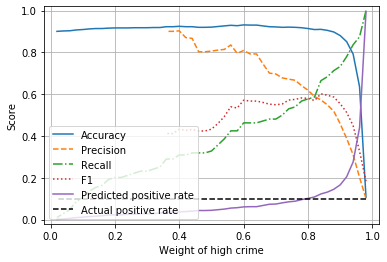

In [112]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [113]:
weight = {0:0.2,1:0.8}

In [114]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [115]:
results

[0.9139189693801345,
 0.6186507936507937,
 0.5772727272727273,
 0.5801341973860482,
 0.10155899925317399]

## Criminal damage and arson

In [116]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['damage_arson'], bin_edges = pd.qcut(devon_cornwall['damage_arson'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [117]:
# Have a look at counts
devon_cornwall['damage_arson'].value_counts()

0    931
1    103
Name: damage_arson, dtype: int64

In [118]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       88.0     1

In [119]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['damage_arson'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [120]:
results = initial_logistic_regression(X,y)

In [121]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [122]:
# Show mean accuracy on test data
results[1]

[0.9134615384615384,
 0.9230769230769231,
 0.9038461538461539,
 0.8942307692307693,
 0.9029126213592233,
 0.9223300970873787,
 0.9029126213592233,
 0.8932038834951457,
 0.883495145631068,
 0.9029126213592233]

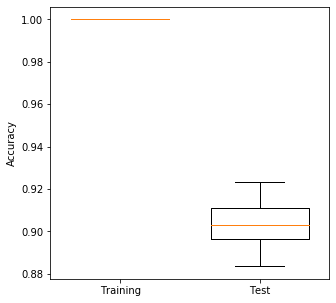

In [123]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [124]:
df = univariate_statistical_selection(X_df,y_df)

In [125]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.580550         0.580550  3.300270e-94   
22                    flat     0.525802         0.525802  1.423485e-74   
2                  married    -0.515931         0.515931  2.108161e-71   
23                  owners    -0.508435         0.508435  4.604262e-69   
14            new_eu_birth     0.466526         0.466526  5.254858e-57   
241                    imd     0.463005         0.463005  4.564938e-56   
1                   single     0.452533         0.452533  2.440085e-53   
33           two_plus_cars    -0.448627         0.448627  2.403912e-52   
243       employment_score     0.442937         0.442937  6.384028e-51   
249                 idaopi     0.441288         0.441288  1.632715e-50   
24            private_rent     0.440261         0.440261  2.923052e-50   
37            unemployment     0.439785         0.439785  3.825782e-50   
253         wider_barriers     0.434963         0.434963  5.704608e-49   
242           income_score     0.431291         0.431291  4.339410e-48   
12           british_birth    -0.421193         0.421193  1.011418e-45   
245           health_score     0.418806         0.418806  3.573448e-45   
35       private_transport    -0.404495         0.404495  5.588491e-42   
36   alternative_transport     0.401597         0.401597  2.372882e-41   
4                    white    -0.399922         0.399922  5.439710e-41   
15                language     0.391599         0.391599  3.127677e-39   

     significant  
26          True  
22          True  
2           True  
23          True  
14          True  
241         True  
1           True  
33          True  
243         True  
249         True  
24          True  
37          True  
253         True  
242         True  
12          True  
245         True  
35          True  
36          True  
4           True  
15          True

In [126]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('damage_arson')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('damage_arson',axis=1) 
y_df = feature_selected['damage_arson'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [127]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [128]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [129]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x0 x5  0.928435  0.926981
1          x5 x10  0.933271  0.927599
2           x5 x6  0.936184  0.927913
3          x5 x19  0.939087  0.928926
4          x7 x17  0.940049  0.928686
5          x5 x12  0.940049  0.927396
6          x7 x19  0.940049  0.926981
7          x2 x10  0.939078  0.925800
8         x11 x12  0.939078  0.925586
9              x5  0.938107  0.924853
10          x0 x4  0.939068  0.925977
11         x5 x14  0.940039  0.926085
12         x5 x18  0.940039  0.926192
13         x4 x19  0.938116  0.924805
14         x2 x11  0.938116  0.924405
15        x15 x17  0.938116  0.923384
16        x12 x13  0.937145  0.922427
17         x2 x13  0.937145  0.922765
18         x4 x15  0.937145  0.924338
19            x16  0.938107  0.920941

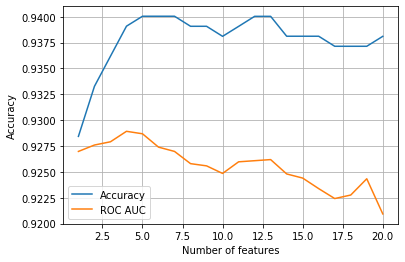

In [130]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

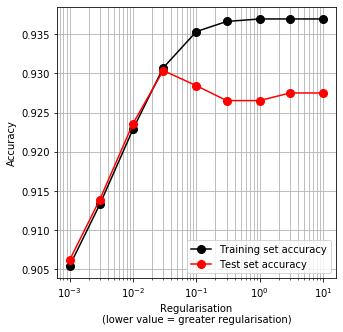

In [131]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.03.

In [132]:
regularisation_value = 0.03

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

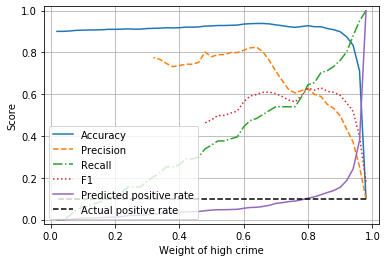

In [133]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [134]:
weight = {0:0.2,1:0.8}

In [135]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [136]:
results

[0.9274365197908887,
 0.6258408258408259,
 0.6454545454545455,
 0.6289050017899124,
 0.10244585511575803]

## Drugs

In [137]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['drugs'], bin_edges = pd.qcut(devon_cornwall['drugs'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [138]:
# Have a look at counts
devon_cornwall['drugs'].value_counts()

0    930
1    104
Name: drugs, dtype: int64

In [139]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       24.7     1

In [140]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['drugs'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [141]:
results = initial_logistic_regression(X,y)

In [142]:
# Show mean accuracy on training data
results[0]

[0.9978494623655914,
 0.9989247311827957,
 0.9989247311827957,
 0.9978494623655914,
 0.9989258861439313,
 0.9978517722878625,
 0.9989258861439313,
 0.9989258861439313,
 1.0,
 0.9978517722878625]

In [143]:
# Show mean accuracy on test data
results[1]

[0.8846153846153846,
 0.9038461538461539,
 0.8846153846153846,
 0.9134615384615384,
 0.8932038834951457,
 0.883495145631068,
 0.9029126213592233,
 0.9611650485436893,
 0.8737864077669902,
 0.9029126213592233]

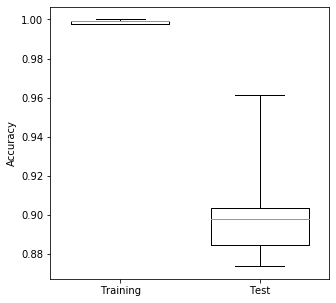

In [144]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [145]:
df = univariate_statistical_selection(X_df,y_df)

In [146]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.567503         0.567503  3.427839e-89   
22                    flat     0.513784         0.513784  9.997631e-71   
2                  married    -0.505637         0.505637  3.321905e-68   
12           british_birth    -0.490973         0.490973  7.783031e-64   
24            private_rent     0.489173         0.489173  2.588960e-63   
4                    white    -0.486268         0.486268  1.774598e-62   
1                   single     0.479888         0.479888  1.139252e-60   
5                    mixed     0.466328         0.466328  5.939782e-57   
36   alternative_transport     0.458648         0.458648  6.395596e-55   
14            new_eu_birth     0.453071         0.453071  1.776460e-53   
23                  owners    -0.431784         0.431784  3.308176e-48   
35       private_transport    -0.429429         0.429429  1.201903e-47   
9                  chinese     0.397877         0.397877  1.488138e-40   
15                language     0.397336         0.397336  1.939883e-40   
83                    m_25     0.395149         0.395149  5.632635e-40   
173                   f_23     0.392425         0.392425  2.102665e-39   
174                   f_24     0.392339         0.392339  2.191348e-39   
10                   black     0.391606         0.391606  3.116521e-39   
82                    m_24     0.389578         0.389578  8.220949e-39   
28             unpaid_care    -0.387419         0.387419  2.290844e-38   

     significant  
26          True  
22          True  
2           True  
12          True  
24          True  
4           True  
1           True  
5           True  
36          True  
14          True  
23          True  
35          True  
9           True  
15          True  
83          True  
173         True  
174         True  
10          True  
82          True  
28          True

In [147]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('drugs')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('drugs',axis=1) 
y_df = feature_selected['drugs'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [148]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [149]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [150]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x1 x7  0.928407  0.884477
1           x7 x9  0.929378  0.884761
2             x14  0.930349  0.894663
3             x12  0.931320  0.895415
4              x3  0.931320  0.893060
5          x0 x18  0.931320  0.892649
6           x2 x7  0.931320  0.891544
7          x5 x12  0.931320  0.892825
8          x8 x14  0.931320  0.891437
9          x2 x17  0.931320  0.890645
10         x3 x17  0.931320  0.889775
11         x3 x14  0.931320  0.890909
12            x17  0.931320  0.890499
13         x4 x14  0.931320  0.890371
14         x5 x14  0.931320  0.890371
15        x12 x17  0.931320  0.890088
16         x0 x17  0.931320  0.890225
17            x18  0.931320  0.888876
18         x9 x14  0.931320  0.888710
19         x3 x12  0.931320  0.889394

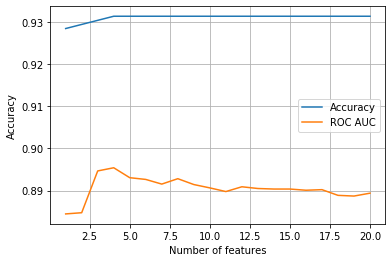

In [151]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

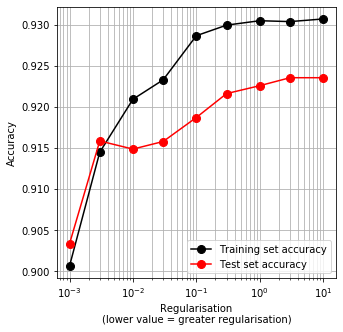

In [152]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:4]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 3.

In [153]:
regularisation_value = 3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

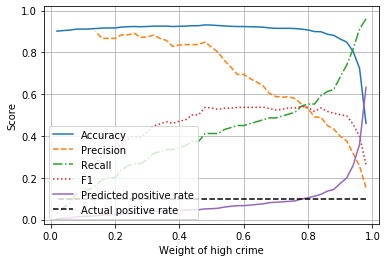

In [154]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [155]:
weight = {0:0.2,1:0.8}

In [156]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [157]:
results

[0.9071135175504107,
 0.5305097680097679,
 0.5527272727272728,
 0.536419527078566,
 0.10438760268857354]

## Other crime

In [158]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_crime'], bin_edges = pd.qcut(devon_cornwall['other_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [159]:
# Have a look at counts
devon_cornwall['other_crime'].value_counts()

0    934
1    100
Name: other_crime, dtype: int64

In [160]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       13.0     1

In [161]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [162]:
results = initial_logistic_regression(X,y)

In [163]:
# Show mean accuracy on training data
results[0]

[0.9935483870967742,
 0.9967741935483871,
 0.9935483870967742,
 0.9989247311827957,
 0.9957035445757251,
 0.9978517722878625,
 0.9946294307196563,
 0.9924812030075187,
 0.9978517722878625,
 0.9978517722878625]

In [164]:
# Show mean accuracy on test data
results[1]

[0.9134615384615384,
 0.875,
 0.9134615384615384,
 0.9038461538461539,
 0.8932038834951457,
 0.8932038834951457,
 0.8932038834951457,
 0.883495145631068,
 0.8640776699029126,
 0.8737864077669902]

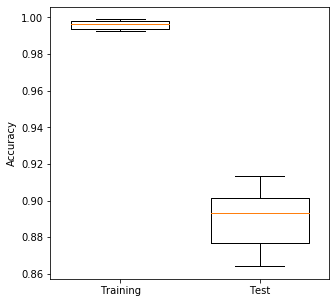

In [165]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [166]:
df = univariate_statistical_selection(X_df,y_df)

In [167]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  significant
26        room_rating     0.430432         0.430432  6.946284e-48         True
23             owners    -0.426476         0.426476  5.976260e-47         True
22               flat     0.404279         0.404279  6.227326e-42         True
14       new_eu_birth     0.404130         0.404130  6.708627e-42         True
2             married    -0.402580         0.402580  1.455353e-41         True
241               imd     0.397637         0.397637  1.673383e-40         True
37       unemployment     0.382740         0.382740  2.057708e-37         True
243  employment_score     0.379858         0.379858  7.815542e-37         True
242      income_score     0.369252         0.369252  9.464167e-35         True
245      health_score     0.367709         0.367709  1.873846e-34         True
1              single     0.366318         0.366318  3.457593e-34         True
249            idaopi     0.363536         0.363536  1.166715e-33         True
15           language     0.361234         0.361234  3.163080e-33         True
248             idaci     0.354996         0.354996  4.530801e-32         True
12      british_birth    -0.353939         0.353939  7.069647e-32         True
87               m_29     0.353637         0.353637  8.026020e-32         True
4               white    -0.350061         0.350061  3.568765e-31         True
33      two_plus_cars    -0.342665         0.342665  7.351099e-30         True
10              black     0.340285         0.340285  1.912545e-29         True
85               m_27     0.327624         0.327624  2.696441e-27         True

In [168]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_crime',axis=1) 
y_df = feature_selected['other_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [169]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [170]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [171]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x5 x19  0.927446  0.856340
1           x3 x7  0.930358  0.862536
2          x6 x15  0.932310  0.875798
3          x7 x10  0.934251  0.874403
4             x19  0.934251  0.873441
5              x5  0.934251  0.872465
6          x0 x17  0.934251  0.873972
7             x11  0.934251  0.871612
8           x4 x5  0.934251  0.870645
9           x4 x8  0.934251  0.867529
10         x5 x14  0.934251  0.867747
11         x5 x16  0.934251  0.868178
12          x0 x7  0.935213  0.868928
13        x16 x19  0.935213  0.868392
14             x8  0.934251  0.867857
15          x0 x4  0.934242  0.866683
16            x17  0.934242  0.863571
17         x7 x14  0.934242  0.862610
18        x11 x17  0.933280  0.862017
19          x1 x7  0.935213  0.860176

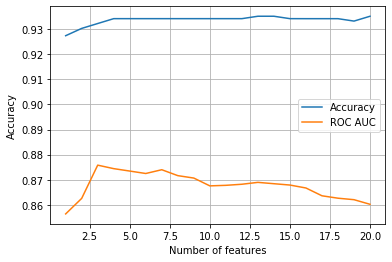

In [172]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

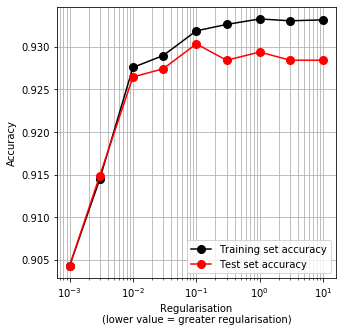

In [173]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:4]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.1.

In [174]:
regularisation_value = 0.1

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

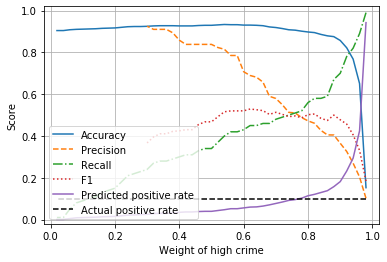

In [175]:
check_weights(X_poly, chosen_features, y)

A weight of 0.75 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [176]:
weight = {0:0.25,1:0.75}

In [177]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [178]:
results

[0.9061519790888722,
 0.5014935064935064,
 0.4999999999999999,
 0.48708507065540313,
 0.09381067961165049]

## Other theft

In [179]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_theft'], bin_edges = pd.qcut(devon_cornwall['other_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [180]:
# Have a look at counts
devon_cornwall['other_theft'].value_counts()

0    930
1    104
Name: other_theft, dtype: int64

In [181]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       62.7     1

In [182]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [183]:
results = initial_logistic_regression(X,y)

In [184]:
# Show mean accuracy on training data
results[0]

[1.0,
 0.9978494623655914,
 0.9978494623655914,
 0.9989247311827957,
 0.9989258861439313,
 0.9978517722878625,
 0.9967776584317938,
 0.9989258861439313,
 0.9957035445757251,
 0.9967776584317938]

In [185]:
# Show mean accuracy on test data
results[1]

[0.8942307692307693,
 0.8942307692307693,
 0.8846153846153846,
 0.9038461538461539,
 0.9029126213592233,
 0.8932038834951457,
 0.8932038834951457,
 0.883495145631068,
 0.9320388349514563,
 0.9029126213592233]

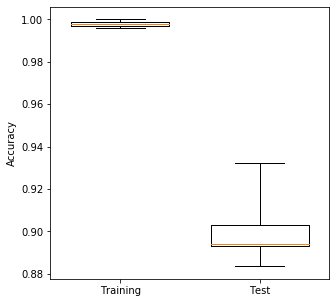

In [186]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [187]:
df = univariate_statistical_selection(X_df,y_df)

In [188]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.495289         0.495289  4.238763e-65   
22                    flat     0.455539         0.455539  4.112697e-54   
14            new_eu_birth     0.418378         0.418378  4.474035e-45   
2                  married    -0.408860         0.408860  6.157937e-43   
12           british_birth    -0.407187         0.407187  1.439330e-42   
23                  owners    -0.388475         0.388475  1.388657e-38   
24            private_rent     0.388341         0.388341  1.479990e-38   
15                language     0.380465         0.380465  5.906318e-37   
4                    white    -0.377102         0.377102  2.764813e-36   
36   alternative_transport     0.376772         0.376772  3.214016e-36   
1                   single     0.368284         0.368284  1.453543e-34   
35       private_transport    -0.352572         0.352572  1.254052e-31   
9                  chinese     0.343061         0.343061  6.264211e-30   
83                    m_25     0.342086         0.342086  9.284203e-30   
174                   f_24     0.340070         0.340070  2.083964e-29   
5                    mixed     0.338934         0.338934  3.279064e-29   
33           two_plus_cars    -0.338126         0.338126  4.521978e-29   
176                   f_26     0.328428         0.328428  1.983163e-27   
173                   f_23     0.322500         0.322500  1.872022e-26   
249                 idaopi     0.321980         0.321980  2.274056e-26   

     significant  
26          True  
22          True  
14          True  
2           True  
12          True  
23          True  
24          True  
15          True  
4           True  
36          True  
1           True  
35          True  
9           True  
83          True  
174         True  
5           True  
33          True  
176         True  
173         True  
249         True

In [189]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_theft',axis=1) 
y_df = feature_selected['other_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [190]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [191]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [192]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x1 x9  0.920715  0.827527
1          x0 x19  0.923646  0.837566
2         x11 x17  0.925588  0.861554
3          x5 x18  0.925597  0.862317
4              x3  0.927530  0.860528
5              x5  0.927530  0.860674
6              x6  0.927530  0.859062
7             x12  0.927530  0.855718
8              x4  0.927530  0.853910
9             x11  0.927530  0.851926
10          x0 x1  0.927530  0.851202
11         x2 x15  0.927530  0.850215
12         x1 x16  0.927530  0.846276
13          x3 x4  0.927530  0.846628
14          x3 x8  0.927530  0.846530
15         x4 x11  0.927530  0.847967
16          x4 x5  0.927530  0.848387
17         x0 x16  0.927530  0.845621
18          x6 x8  0.926568  0.845396
19         x2 x14  0.926568  0.843353

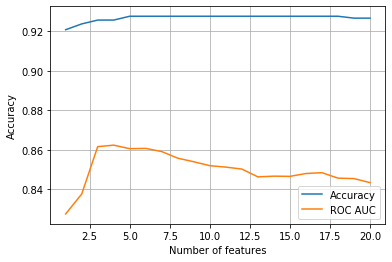

In [193]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

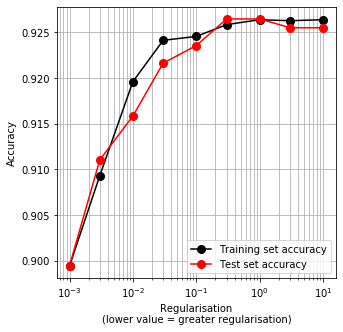

In [194]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.3.

In [195]:
regularisation_value = 0.3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

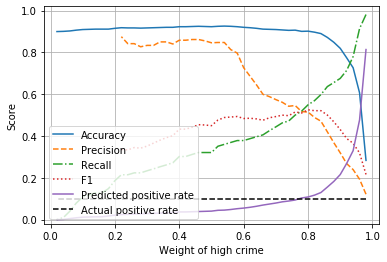

In [196]:
check_weights(X_poly, chosen_features, y)

A weight of 0.75 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [197]:
weight = {0:0.25,1:0.75}

In [198]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [199]:
results

[0.9062173263629575,
 0.548517316017316,
 0.4909090909090909,
 0.5105000809005386,
 0.09185959671396564]

## Possession of weapons

In [200]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['possession_weapons'], bin_edges = pd.qcut(devon_cornwall['possession_weapons'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [201]:
# Have a look at counts
devon_cornwall['possession_weapons'].value_counts()

0    941
1     93
Name: possession_weapons, dtype: int64

In [202]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [203]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['possession_weapons'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [204]:
results = initial_logistic_regression(X,y)

In [205]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [206]:
# Show mean accuracy on test data
results[1]

[0.8942307692307693,
 0.9615384615384616,
 0.9038461538461539,
 0.8942307692307693,
 0.9029126213592233,
 0.941747572815534,
 0.9514563106796117,
 0.9029126213592233,
 0.8737864077669902,
 0.9320388349514563]

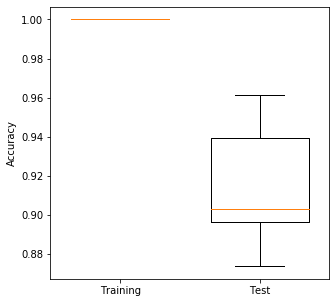

In [207]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [208]:
df = univariate_statistical_selection(X_df,y_df)

In [209]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.555374         0.555374  1.003849e-84   
22                    flat     0.506784         0.506784  1.480674e-68   
2                  married    -0.474992         0.474992  2.618493e-59   
14            new_eu_birth     0.469112         0.469112  1.057180e-57   
24            private_rent     0.463005         0.463005  4.563613e-56   
23                  owners    -0.459195         0.459195  4.601280e-55   
12           british_birth    -0.457281         0.457281  1.453213e-54   
4                    white    -0.443676         0.443676  4.185029e-51   
1                   single     0.433820         0.433820  1.075876e-48   
36   alternative_transport     0.409525         0.409525  4.386228e-43   
15                language     0.406948         0.406948  1.624314e-42   
5                    mixed     0.401308         0.401308  2.739761e-41   
35       private_transport    -0.397513         0.397513  1.778848e-40   
33           two_plus_cars    -0.391515         0.391515  3.255949e-39   
253         wider_barriers     0.384464         0.384464  9.201076e-38   
241                    imd     0.375484         0.375484  5.773093e-36   
249                 idaopi     0.372499         0.372499  2.220861e-35   
9                  chinese     0.371286         0.371286  3.824499e-35   
245           health_score     0.365228         0.365228  5.577472e-34   
243       employment_score     0.361644         0.361644  2.649828e-33   

     significant  
26          True  
22          True  
2           True  
14          True  
24          True  
23          True  
12          True  
4           True  
1           True  
36          True  
15          True  
5           True  
35          True  
33          True  
253         True  
241         True  
249         True  
9           True  
245         True  
243         True

In [210]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('possession_weapons')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('possession_weapons',axis=1) 
y_df = feature_selected['possession_weapons'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [211]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [212]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [213]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x0 x18  0.936146  0.841980
1           x1 x9  0.939078  0.889613
2           x3 x5  0.942952  0.893231
3              x1  0.942952  0.893210
4              x3  0.942952  0.893080
5              x6  0.942952  0.893551
6         x11 x17  0.943913  0.889931
7             x13  0.943923  0.892936
8              x9  0.943923  0.892676
9           x1 x7  0.943923  0.892570
10         x0 x17  0.943923  0.892521
11          x1 x6  0.943923  0.892981
12         x8 x14  0.943923  0.892225
13          x1 x3  0.943923  0.892345
14         x1 x14  0.943923  0.892097
15         x6 x13  0.943923  0.891850
16          x3 x7  0.943923  0.891495
17         x3 x13  0.943923  0.891046
18          x7 x9  0.943923  0.890502
19         x7 x13  0.943923  0.891507

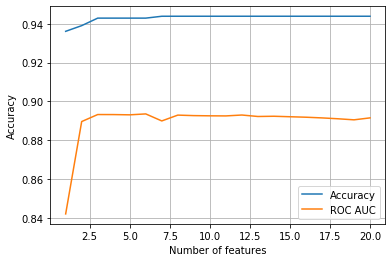

In [214]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

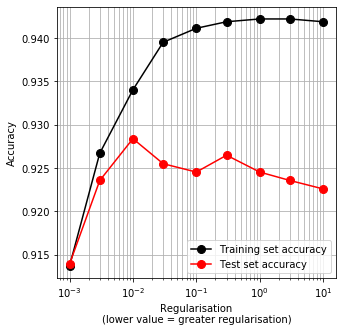

In [215]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:8]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.01.

In [216]:
regularisation_value = 0.01

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

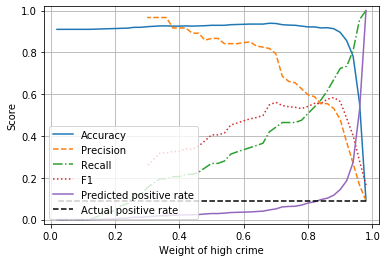

In [217]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [218]:
weight = {0:0.2,1:0.8}

In [219]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [220]:
results

[0.9217046303211351,
 0.596984126984127,
 0.5077777777777778,
 0.5417915890439111,
 0.07931292008961911]

## Public order offences

In [221]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['public_order'], bin_edges = pd.qcut(devon_cornwall['public_order'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [222]:
# Have a look at counts
devon_cornwall['public_order'].value_counts()

0    932
1    102
Name: public_order, dtype: int64

In [223]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       40.0     1

In [224]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['public_order'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [225]:
results = initial_logistic_regression(X,y)

In [226]:
# Show mean accuracy on training data
results[0]

[1.0,
 1.0,
 1.0,
 1.0,
 0.9989258861439313,
 0.9989258861439313,
 1.0,
 1.0,
 0.9989258861439313,
 0.9989258861439313]

In [227]:
# Show mean accuracy on test data
results[1]

[0.9134615384615384,
 0.8557692307692307,
 0.9326923076923077,
 0.8653846153846154,
 0.9029126213592233,
 0.8932038834951457,
 0.9029126213592233,
 0.8737864077669902,
 0.9029126213592233,
 0.9514563106796117]

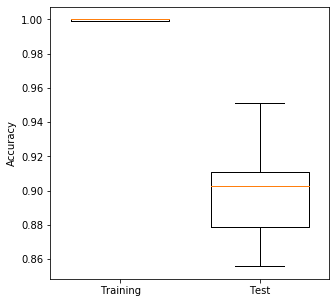

In [228]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [229]:
df = univariate_statistical_selection(X_df,y_df)

In [230]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26             room_rating     0.496251         0.496251  2.201937e-65   
22                    flat     0.477013         0.477013  7.222039e-60   
23                  owners    -0.438326         0.438326  8.704497e-50   
2                  married    -0.438285         0.438285  8.905379e-50   
24            private_rent     0.395500         0.395500  4.749763e-40   
12           british_birth    -0.389186         0.389186  9.907872e-39   
14            new_eu_birth     0.385615         0.385615  5.362712e-38   
33           two_plus_cars    -0.383551         0.383551  1.409967e-37   
4                    white    -0.378520         0.378520  1.445542e-36   
1                   single     0.377714         0.377714  2.090366e-36   
36   alternative_transport     0.371942         0.371942  2.851812e-35   
249                 idaopi     0.370784         0.370784  4.785643e-35   
243       employment_score     0.368342         0.368342  1.416451e-34   
35       private_transport    -0.367043         0.367043  2.514012e-34   
241                    imd     0.366040         0.366040  3.906866e-34   
253         wider_barriers     0.354692         0.354692  5.150801e-32   
5                    mixed     0.349814         0.349814  3.953874e-31   
242           income_score     0.346919         0.346919  1.303114e-30   
245           health_score     0.344976         0.344976  2.881698e-30   
37            unemployment     0.344344         0.344344  3.724528e-30   

     significant  
26          True  
22          True  
23          True  
2           True  
24          True  
12          True  
14          True  
33          True  
4           True  
1           True  
36          True  
249         True  
243         True  
35          True  
241         True  
253         True  
5           True  
242         True  
245         True  
37          True

In [231]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('public_order')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('public_order',axis=1) 
y_df = feature_selected['public_order'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [232]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [233]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [234]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x4 x14  0.921649  0.836015
1         x10 x14  0.926484  0.859425
2          x6 x14  0.928417  0.860236
3             x18  0.928417  0.858322
4          x0 x14  0.928417  0.858341
5          x2 x11  0.928417  0.856669
6             x19  0.928417  0.855505
7          x0 x17  0.928417  0.855190
8           x2 x4  0.928417  0.854332
9          x5 x18  0.928417  0.854545
10         x6 x12  0.928417  0.853727
11         x1 x15  0.928417  0.851732
12         x2 x17  0.928417  0.848871
13          x1 x9  0.930358  0.864428
14         x9 x17  0.931329  0.862246
15         x9 x15  0.932291  0.861756
16            x14  0.932291  0.860047
17          x1 x5  0.932291  0.859196
18          x1 x6  0.932291  0.859516
19         x1 x19  0.932291  0.857583

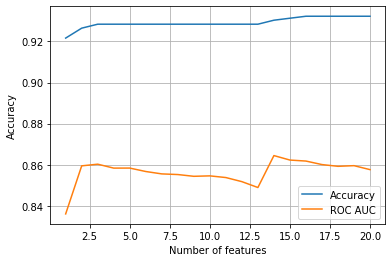

In [235]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

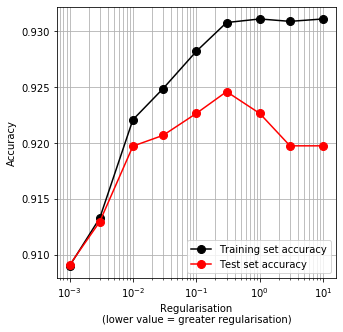

In [236]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:14]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.3.

In [237]:
regularisation_value = 0.3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

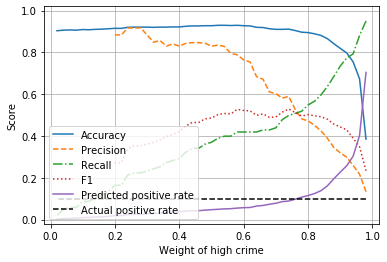

In [238]:
check_weights(X_poly, chosen_features, y)

A weight of 0.75 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [239]:
weight = {0:0.25,1:0.75}

In [240]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [241]:
results

[0.9071601941747574,
 0.5616785991785991,
 0.49818181818181817,
 0.5181744808040406,
 0.09283980582524272]

## Robbery

In [242]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['robbery'], bin_edges = pd.qcut(devon_cornwall['robbery'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [243]:
# Have a look at counts
devon_cornwall['robbery'].value_counts()

0    941
1     93
Name: robbery, dtype: int64

In [244]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        4.0     1

In [245]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['robbery'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [246]:
results = initial_logistic_regression(X,y)

In [247]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [248]:
# Show mean accuracy on test data
results[1]

[0.9326923076923077,
 0.9134615384615384,
 0.9326923076923077,
 0.9230769230769231,
 0.9320388349514563,
 0.9320388349514563,
 0.9223300970873787,
 0.9223300970873787,
 0.9514563106796117,
 0.8932038834951457]

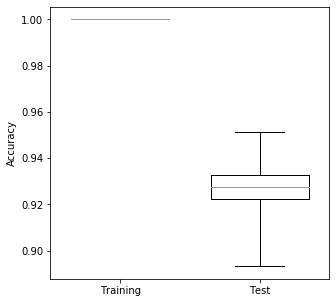

In [249]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [250]:
df = univariate_statistical_selection(X_df,y_df)

In [251]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation   significance  \
26             room_rating     0.608792         0.608792  7.016327e-106   
22                    flat     0.576709         0.576709   1.043734e-92   
2                  married    -0.537910         0.537910   1.314211e-78   
24            private_rent     0.536654         0.536654   3.506227e-78   
12           british_birth    -0.522560         0.522560   1.608079e-73   
14            new_eu_birth     0.522263         0.522263   2.005639e-73   
1                   single     0.499449         0.499449   2.461582e-66   
23                  owners    -0.489079         0.489079   2.757046e-63   
15                language     0.483644         0.483644   9.933832e-62   
4                    white    -0.481761         0.481761   3.387188e-61   
36   alternative_transport     0.463140         0.463140   4.203758e-56   
35       private_transport    -0.458432         0.458432   7.285998e-55   
5                    mixed     0.454046         0.454046   9.979106e-54   
33           two_plus_cars    -0.431516         0.431516   3.832859e-48   
174                   f_24     0.415012         0.415012   2.600178e-44   
28             unpaid_care    -0.412861         0.412861   7.921910e-44   
9                  chinese     0.410685         0.410685   2.424807e-43   
173                   f_23     0.410098         0.410098   3.274491e-43   
13            old_eu_birth     0.404235         0.404235   6.367354e-42   
253         wider_barriers     0.404009         0.404009   7.127289e-42   

     significant  
26          True  
22          True  
2           True  
24          True  
12          True  
14          True  
1           True  
23          True  
15          True  
4           True  
36          True  
35          True  
5           True  
33          True  
174         True  
28          True  
9           True  
173         True  
13          True  
253         True

In [252]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('robbery')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('robbery',axis=1) 
y_df = feature_selected['robbery'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [253]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [254]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [255]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0           x1 x6  0.940982  0.924948
1           x1 x7  0.940991  0.922873
2          x4 x11  0.942924  0.921026
3             x11  0.942924  0.921677
4          x9 x11  0.942924  0.921242
5           x0 x7  0.942924  0.921606
6              x4  0.942924  0.922067
7          x0 x12  0.942924  0.921847
8           x2 x6  0.943895  0.920086
9              x6  0.943895  0.917868
10          x4 x9  0.943895  0.918329
11          x4 x6  0.943895  0.918920
12          x6 x9  0.943895  0.919262
13         x7 x12  0.943895  0.917966
14        x14 x18  0.943895  0.907861
15            x12  0.943904  0.909827
16        x11 x12  0.944866  0.905910
17        x10 x11  0.944866  0.913805
18         x1 x13  0.944884  0.921848
19         x2 x18  0.945855  0.921874

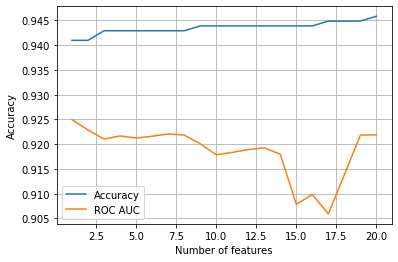

In [256]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

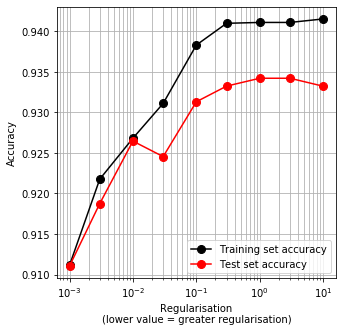

In [257]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:7]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 1.

In [258]:
regularisation_value = 1

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

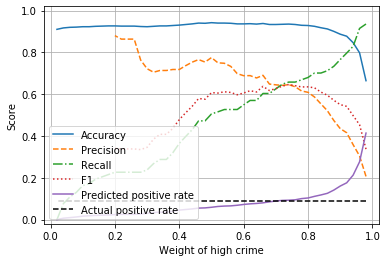

In [259]:
check_weights(X_poly, chosen_features, y)

A weight of 0.7 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [260]:
weight = {0:0.3,1:0.7}

In [261]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [262]:
results

[0.9332710978342046,
 0.6446103896103896,
 0.6255555555555556,
 0.6267797166713575,
 0.08899365197908886]

## Shoplifting

In [263]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['shoplifting'], bin_edges = pd.qcut(devon_cornwall['shoplifting'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [264]:
# Have a look at counts
devon_cornwall['shoplifting'].value_counts()

0    930
1    104
Name: shoplifting, dtype: int64

In [265]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       58.7     1

In [266]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['shoplifting'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [267]:
results = initial_logistic_regression(X,y)

In [268]:
# Show mean accuracy on training data
results[0]

[0.9946236559139785,
 0.9935483870967742,
 0.9935483870967742,
 0.9935483870967742,
 0.9935553168635876,
 0.9935553168635876,
 0.9935553168635876,
 0.9989258861439313,
 0.9903329752953813,
 0.9967776584317938]

In [269]:
# Show mean accuracy on test data
results[1]

[0.875,
 0.8365384615384616,
 0.875,
 0.8653846153846154,
 0.8640776699029126,
 0.883495145631068,
 0.8737864077669902,
 0.8543689320388349,
 0.9320388349514563,
 0.8543689320388349]

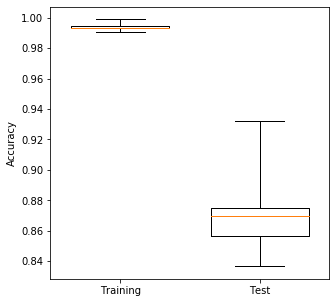

In [270]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [271]:
df = univariate_statistical_selection(X_df,y_df)

In [272]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
22                    flat     0.394545         0.394545  7.553969e-40   
26             room_rating     0.388368         0.388368  1.461587e-38   
14            new_eu_birth     0.356909         0.356909  2.015549e-32   
24            private_rent     0.339158         0.339158  2.998778e-29   
2                  married    -0.336602         0.336602  8.262809e-29   
23                  owners    -0.321386         0.321386  2.838074e-26   
33           two_plus_cars    -0.317665         0.317665  1.125877e-25   
36   alternative_transport     0.317020         0.317020  1.426744e-25   
243       employment_score     0.304424         0.304424  1.298262e-23   
15                language     0.296902         0.296902  1.731668e-22   
12           british_birth    -0.289301         0.289301  2.197221e-21   
37            unemployment     0.286995         0.286995  4.676593e-21   
3                 divorced     0.286633         0.286633  5.262940e-21   
253         wider_barriers     0.281682         0.281682  2.597414e-20   
35       private_transport    -0.280225         0.280225  4.130404e-20   
249                 idaopi     0.278333         0.278333  7.510766e-20   
241                    imd     0.271726         0.271726  5.847720e-19   
242           income_score     0.267251         0.267251  2.273917e-18   
1                   single     0.263964         0.263964  6.067953e-18   
245           health_score     0.261249         0.261249  1.350732e-17   

     significant  
22          True  
26          True  
14          True  
24          True  
2           True  
23          True  
33          True  
36          True  
243         True  
15          True  
12          True  
37          True  
3           True  
253         True  
35          True  
249         True  
241         True  
242         True  
1           True  
245         True

In [273]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('shoplifting')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('shoplifting',axis=1) 
y_df = feature_selected['shoplifting'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [274]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [275]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [276]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x1 x12  0.909130  0.810919
1          x3 x12  0.913966  0.816354
2          x1 x19  0.915907  0.813675
3           x7 x8  0.918801  0.832610
4           x6 x7  0.919772  0.832512
5           x4 x6  0.920734  0.831652
6          x3 x18  0.921705  0.829736
7           x2 x9  0.921705  0.829169
8             x12  0.921705  0.829726
9           x5 x6  0.921705  0.828935
10         x9 x13  0.922666  0.828847
11             x3  0.922666  0.828690
12         x3 x10  0.921705  0.828240
13         x4 x13  0.921705  0.825191
14         x5 x13  0.921705  0.824976
15          x0 x4  0.920743  0.820538
16            x18  0.919782  0.817566
17          x4 x5  0.918820  0.817898
18         x6 x18  0.918820  0.818319
19         x8 x19  0.918820  0.816891

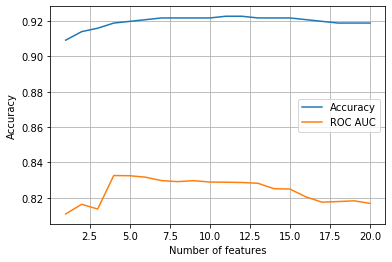

In [277]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

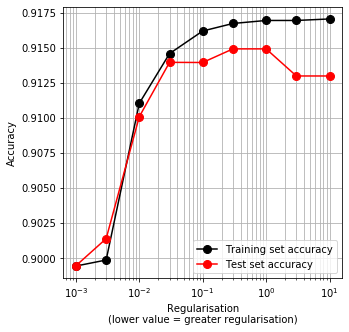

In [278]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 1.

In [279]:
regularisation_value = 1

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

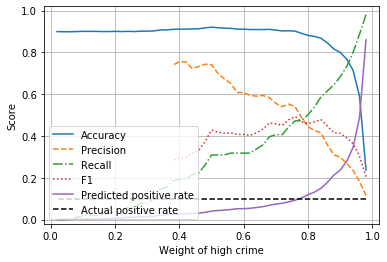

In [280]:
check_weights(X_poly, chosen_features, y)

A weight of 0.78 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [281]:
weight = {0:0.22,1:0.78}

In [282]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [283]:
results

[0.8907766990291263,
 0.48654345654345654,
 0.47272727272727266,
 0.46808545248442934,
 0.10345407020164302]

## Theft from the person

In [284]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['theft_person'], bin_edges = pd.qcut(devon_cornwall['theft_person'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [285]:
# Have a look at counts
devon_cornwall['theft_person'].value_counts()

0    934
1    100
Name: theft_person, dtype: int64

In [286]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        5.0     1

In [287]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['theft_person'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [288]:
results = initial_logistic_regression(X,y)

In [289]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [290]:
# Show mean accuracy on test data
results[1]

[0.9230769230769231,
 0.8942307692307693,
 0.9423076923076923,
 0.9230769230769231,
 0.912621359223301,
 0.8932038834951457,
 0.9320388349514563,
 0.912621359223301,
 0.9223300970873787,
 0.8640776699029126]

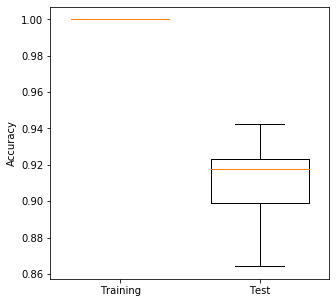

In [291]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [292]:
df = univariate_statistical_selection(X_df,y_df)

In [293]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  \
26              room_rating     0.559912         0.559912  2.249505e-86   
22                     flat     0.554927         0.554927  1.454801e-84   
24             private_rent     0.513042         0.513042  1.707520e-70   
12            british_birth    -0.490585         0.490585  1.009119e-63   
2                   married    -0.475631         0.475631  1.743608e-59   
4                     white    -0.455009         0.455009  5.635990e-54   
14             new_eu_birth     0.451405         0.451405  4.740265e-53   
36    alternative_transport     0.436323         0.436323  2.673692e-49   
23                   owners    -0.428422         0.428422  2.080619e-47   
35        private_transport    -0.427684         0.427684  3.105943e-47   
1                    single     0.423719         0.423719  2.632366e-46   
5                     mixed     0.410991         0.410991  2.072853e-43   
9                   chinese     0.403754         0.403754  8.098737e-42   
15                 language     0.398375         0.398375  1.165433e-40   
17   non_dependent_children    -0.385235         0.385235  6.411253e-38   
174                    f_24     0.384473         0.384473  9.163696e-38   
33            two_plus_cars    -0.383826         0.383826  1.240183e-37   
13             old_eu_birth     0.375975         0.375975  4.620443e-36   
28              unpaid_care    -0.367188         0.367188  2.357754e-34   
83                     m_25     0.366798         0.366798  2.800044e-34   

     significant  
26          True  
22          True  
24          True  
12          True  
2           True  
4           True  
14          True  
36          True  
23          True  
35          True  
1           True  
5           True  
9           True  
15          True  
17          True  
174         True  
33          True  
13          True  
28          True  
83          True

In [294]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('theft_person')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('theft_person',axis=1) 
y_df = feature_selected['theft_person'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [295]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [296]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [297]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0         x14 x16  0.927474  0.879252
1           x4 x6  0.929425  0.880900
2             x16  0.929444  0.879828
3          x4 x17  0.930405  0.878431
4          x3 x16  0.930405  0.879920
5          x5 x16  0.930405  0.880453
6          x6 x14  0.930396  0.878626
7         x10 x14  0.929434  0.875522
8          x4 x10  0.929434  0.876270
9          x7 x14  0.929434  0.876803
10         x4 x18  0.929388  0.893177
11         x9 x16  0.931320  0.892640
12        x16 x18  0.932282  0.894242
13         x2 x12  0.932282  0.892956
14        x10 x12  0.934205  0.900326
15         x9 x11  0.935176  0.898049
16        x11 x19  0.936146  0.896437
17         x7 x16  0.936146  0.894730
18         x6 x12  0.935185  0.894839
19        x11 x12  0.936146  0.895162

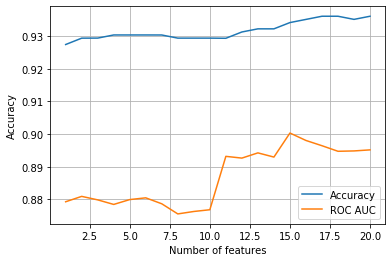

In [298]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

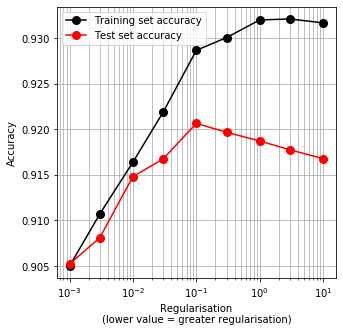

In [299]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:15]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.1.

In [300]:
regularisation_value = 0.1

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

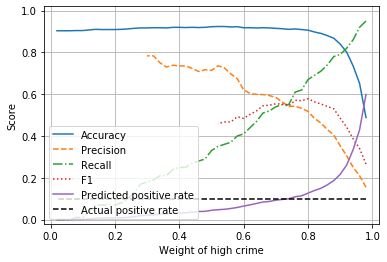

In [301]:
check_weights(X_poly, chosen_features, y)

A weight of 0.7 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [302]:
weight = {0:0.3,1:0.7}

In [303]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [304]:
results

[0.9148805078416729,
 0.5841558441558441,
 0.54,
 0.5539822595704949,
 0.09286781179985062]

## Vehicle crime

In [305]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['vehicle_crime'], bin_edges = pd.qcut(devon_cornwall['vehicle_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [306]:
# Have a look at counts
devon_cornwall['vehicle_crime'].value_counts()

0    932
1    102
Name: vehicle_crime, dtype: int64

In [307]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       31.0     1

In [308]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['vehicle_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [309]:
results = initial_logistic_regression(X,y)

In [310]:
# Show mean accuracy on training data
results[0]

[0.9946236559139785,
 0.9935483870967742,
 0.9946236559139785,
 0.9989247311827957,
 0.9957035445757251,
 0.9989258861439313,
 0.9957035445757251,
 0.9946294307196563,
 0.9946294307196563,
 0.9935553168635876]

In [311]:
# Show mean accuracy on test data
results[1]

[0.9134615384615384,
 0.8653846153846154,
 0.8653846153846154,
 0.875,
 0.8737864077669902,
 0.8543689320388349,
 0.8932038834951457,
 0.883495145631068,
 0.8543689320388349,
 0.8252427184466019]

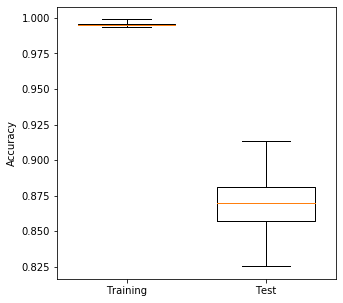

In [312]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [313]:
df = univariate_statistical_selection(X_df,y_df)

In [314]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  significant
14     new_eu_birth     0.383939         0.383939  1.176114e-37         True
22             flat     0.368224         0.368224  1.492761e-34         True
12    british_birth    -0.362853         0.362853  1.569730e-33         True
24     private_rent     0.358448         0.358448  1.046383e-32         True
26      room_rating     0.354516         0.354516  5.545292e-32         True
2           married    -0.349568         0.349568  4.377807e-31         True
1            single     0.348475         0.348475  6.873877e-31         True
5             mixed     0.337179         0.337179  6.578427e-29         True
90             m_32     0.334187         0.334187  2.134731e-28         True
255  outdoors_score     0.333519         0.333519  2.771210e-28         True
4             white    -0.328838         0.328838  1.694934e-27         True
10            black     0.327472         0.327472  2.857398e-27         True
86             m_28     0.316878         0.316878  1.503189e-25         True
176            f_26     0.312599         0.312599  7.126065e-25         True
91             m_33     0.309256         0.309256  2.360871e-24         True
85             m_27     0.307058         0.307058  5.147304e-24         True
93             m_35     0.307027         0.307027  5.204550e-24         True
87             m_29     0.306847         0.306847  5.544130e-24         True
174            f_24     0.299130         0.299130  8.102764e-23         True
83             m_25     0.293627         0.293627  5.222580e-22         True

In [315]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('vehicle_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('vehicle_crime',axis=1) 
y_df = feature_selected['vehicle_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [316]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [317]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [318]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x1 x16  0.914862  0.811660
1           x3 x8  0.921611  0.842748
2          x9 x15  0.926456  0.829685
3           x4 x7  0.928407  0.826937
4         x13 x16  0.930340  0.837698
5          x0 x11  0.931311  0.836656
6          x1 x19  0.931320  0.835365
7          x0 x14  0.931320  0.835023
8          x4 x16  0.931320  0.835638
9          x0 x12  0.931320  0.834143
10         x4 x14  0.931311  0.831567
11         x7 x13  0.931311  0.831147
12          x0 x5  0.930349  0.830054
13         x6 x13  0.930349  0.829228
14         x1 x13  0.930340  0.829298
15          x0 x7  0.930340  0.826492
16             x4  0.930340  0.824408
17         x1 x11  0.929378  0.824692
18             x0  0.929388  0.823825
19             x2  0.929397  0.824209

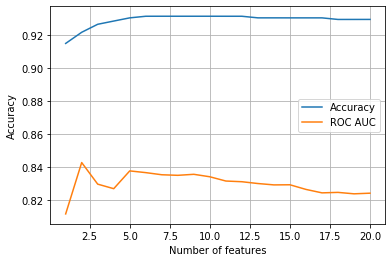

In [319]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

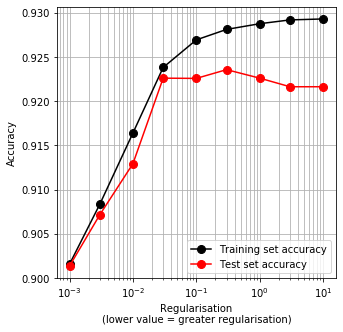

In [320]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:5]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.3.

In [321]:
regularisation_value = 0.3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

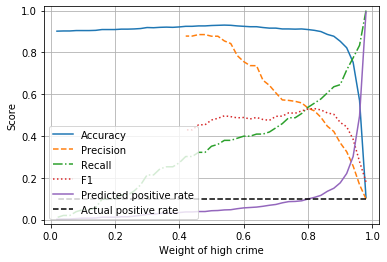

In [322]:
check_weights(X_poly, chosen_features, y)

A weight of 0.8 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [323]:
weight = {0:0.2,1:0.8}

In [324]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [325]:
results

[0.9090832710978342,
 0.5335768398268399,
 0.5372727272727273,
 0.528748382680271,
 0.09866504854368932]

## Violence and sexual offences

In [326]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['violence_sexual'], bin_edges = pd.qcut(devon_cornwall['violence_sexual'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [327]:
# Have a look at counts
devon_cornwall['violence_sexual'].value_counts()

0    930
1    104
Name: violence_sexual, dtype: int64

In [328]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       14.0     0
1      251.7     1

In [329]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['violence_sexual'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [330]:
results = initial_logistic_regression(X,y)

In [331]:
# Show mean accuracy on training data
results[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [332]:
# Show mean accuracy on test data
results[1]

[0.9326923076923077,
 0.9326923076923077,
 0.8942307692307693,
 0.9134615384615384,
 0.9320388349514563,
 0.9029126213592233,
 0.912621359223301,
 0.883495145631068,
 0.9320388349514563,
 0.941747572815534]

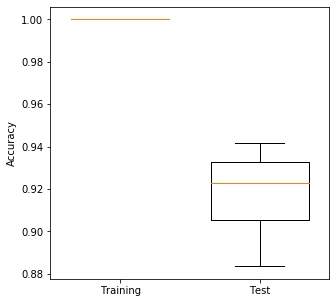

In [333]:
plot_initial_accuracy(results)

Let's try to improve the accuracy. We'll start by doing some feature selection.

In [334]:
df = univariate_statistical_selection(X_df,y_df)

In [335]:
top_features = top_20_features(df)
# Look at top features
df.head(20)

feature  correlation  abs_correlation  significance  significant
26        room_rating     0.577516         0.577516  5.070502e-93         True
22               flat     0.541114         0.541114  1.054657e-79         True
23             owners    -0.531542         0.531542  1.823278e-76         True
2             married    -0.512546         0.512546  2.440621e-70         True
14       new_eu_birth     0.492821         0.492821  2.249483e-64         True
241               imd     0.488658         0.488658  3.647224e-63         True
1              single     0.467014         0.467014  3.886930e-57         True
243  employment_score     0.465237         0.465237  1.162925e-56         True
37       unemployment     0.459805         0.459805  3.183999e-55         True
242      income_score     0.448884         0.448884  2.069412e-52         True
12      british_birth    -0.447695         0.447695  4.130915e-52         True
249            idaopi     0.438619         0.438619  7.382440e-50         True
245      health_score     0.435374         0.435374  4.539817e-49         True
4               white    -0.433732         0.433732  1.129451e-48         True
253    wider_barriers     0.433698         0.433698  1.150902e-48         True
24       private_rent     0.430419         0.430419  6.998932e-48         True
15           language     0.428452         0.428452  2.046989e-47         True
33      two_plus_cars    -0.424729         0.424729  1.531064e-46         True
175              f_25     0.417590         0.417590  6.769312e-45         True
248             idaci     0.416925         0.416925  9.588298e-45         True

In [336]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('violence_sexual')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('violence_sexual',axis=1) 
y_df = feature_selected['violence_sexual'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

To allow for feature interaction, let's do some polynomial expansion.

In [337]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

In [338]:
results_and_features = select_from_expanded_features(poly,X_poly,y)

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [339]:
# Look at results
results_and_features[0]

feature to add  accuracy       auc
0          x4 x12  0.938135  0.867644
1          x1 x19  0.943951  0.898475
2         x11 x13  0.945883  0.898954
3             x11  0.945883  0.901652
4          x3 x12  0.945883  0.897067
5           x5 x6  0.946817  0.918866
6           x0 x8  0.947797  0.919355
7          x8 x11  0.949729  0.918729
8           x3 x9  0.950700  0.919472
9         x17 x18  0.950700  0.944897
10          x6 x9  0.951671  0.944907
11         x0 x11  0.951671  0.944800
12             x0  0.951671  0.944897
13          x0 x1  0.951671  0.944946
14            x14  0.950700  0.944106
15          x3 x8  0.951671  0.944213
16         x0 x10  0.951671  0.943793
17         x5 x12  0.951671  0.943275
18         x0 x13  0.950700  0.943060
19         x1 x12  0.949729  0.941457

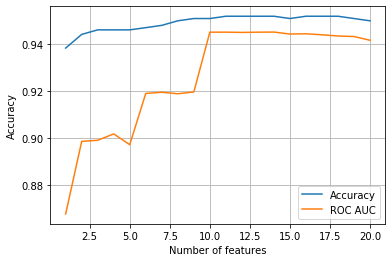

In [340]:
plot_accuracy(results_and_features)

Now let's find the optimal regularisation value.

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

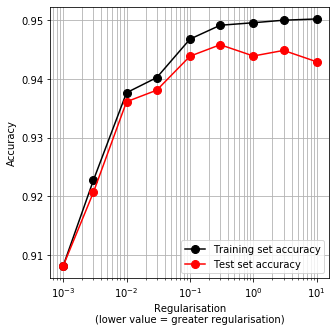

In [341]:
# Create list of ordered polynomial features
chosen_features = results_and_features[1][0:10]

check_regularisation(X_poly, chosen_features, y_df)

The optimal regularisation value would seem to be 0.3.

In [342]:
regularisation_value = 0.3

Finally let's deal with the imbalance of the data. As changing the class weights was previously most effective, we will try this again. 

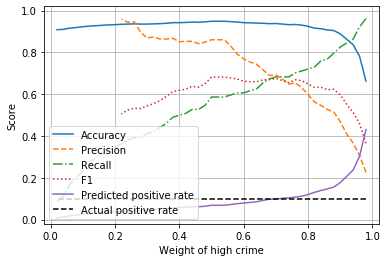

In [343]:
check_weights(X_poly, chosen_features, y)

A weight of 0.7 for high crime estimates the correct proportions and balances accuracy, precision and recall.

In [344]:
weight = {0:0.3,1:0.7}

In [345]:
results = weighted_logistic_regression(X_poly, chosen_features, y)

In [346]:
results

[0.9381161314413742,
 0.6920712620712621,
 0.6827272727272727,
 0.6755182206854035,
 0.09862770724421208]